In [11]:
import os
import sys
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from hydra import initialize, compose
from glob import glob
from tqdm import tqdm
from phrosty import plotting

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import roman_util, util
from mejiro.lenses import lens_util
from mejiro.plots import plot_util

In [12]:
masses = np.arange(1e8, 1e10, 5e7)
# masses = np.linspace(1e9, 1e10, 20)
sides = 4  # 3

In [13]:
print(len(masses))

198


In [14]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'lowest_detectable_subhalo_mass_dev')
results = util.unpickle_all(save_dir, 'results_', '.pkl')
detectable_halos = util.unpickle_all(save_dir, 'detectable_halos_', '.pkl')

file_list = glob(save_dir + f"/results_*.pkl")
sorted_list = sorted(file_list)
uids = [os.path.basename(f).split('_')[1][:-4] for f in sorted_list]
# pprint(uids)

pval_threshold = 0.001  # three sigma

In [15]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = False  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=False, verbose=True)

100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


In [16]:
positions = []
for i in range(1, 19):
    sca = str(i).zfill(2)
    coords = roman_util.divide_up_sca(sides)
    for coord in coords:
        positions.append((sca, coord))

 14%|█▍        | 28/198 [00:00<00:01, 133.49it/s]

100%|██████████| 198/198 [00:01<00:00, 141.54it/s]


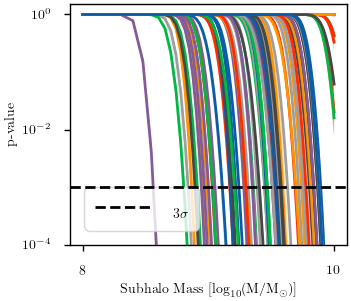

In [17]:
f, ax = plt.subplots(1, 1, figsize=(3.5, 3), constrained_layout=True)  # 

for result in results:
    mass_pvals, uplims, lolims = [], [], []
    for mass in tqdm(masses):

        position_pvals, maxes, mins = [], [], []
        for position_key in list(results[0].keys()):
            pvals = result[position_key][str(int(mass))]
            position_pvals.append(np.median(pvals))

        maxes.append(np.max(position_pvals))
        mins.append(np.min(position_pvals))
        mass_pvals.append(np.median(position_pvals))
        uplims.append(np.max(position_pvals))
        lolims.append(np.min(position_pvals))

    ax.plot(np.log10(masses), mass_pvals)
    ax.fill_between(np.log10(masses), uplims, lolims, alpha=0.3)

ax.axhline(pval_threshold, color='black', linestyle='--', label=f'3$\sigma$', zorder=1e3)

ax.set_xlabel(r'Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
ax.set_ylabel('p-value')
# plt.xscale('log')
plt.yscale('log')
# ax.set_xlim(9.5, 10)
ax.set_ylim(10e-5, 1.5e0)
ax.legend()  # loc='upper right'

for item in ([ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels() + 
              ax.get_legend().get_texts()):
     item.set_fontsize(10)

plt.savefig(os.path.join(figure_dir, 'pvals_all.png'))
plt.show()

In [18]:
# all systems must have a detectable subhalo at least somewhere in the mass range at all positions across the focal plane
results_to_delete = set()
for k, result in enumerate(results):
    for sca, sca_position in positions:
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = result[position_key]

        largest_mass_pvals = position_results[str(int(masses[-1]))]
        if np.min(largest_mass_pvals) > pval_threshold:
            print(f'Result {k + 1} at position {position_key} has no detectable subhalo at largest mass {masses[-1]:.2e}')
            results_to_delete.add(k)

print(f'{len(results_to_delete)} result(s) to delete')

results = [result for i, result in enumerate(results) if i not in results_to_delete]
print(f'Keeping {len(results)} result(s)')

Result 1 at position 1_511_511 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_511_1533 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_511_2555 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_511_3577 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_1533_511 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_1533_1533 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_1533_2555 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_1533_3577 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_2555_511 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_2555_1533 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_2555_2555 has no detectable subhalo at largest mass 9.95e+09
Result 1 at position 1_2555_3577 has no detectable subhalo at largest mass 9.95e+09

13 result(s) to delete
Keeping 65 result(s)


In [19]:
# randomly select some results to plot
idxs = np.random.randint(0, len(results), 7)

# sort results by redshift
results_to_plot = []

for idx in idxs:
    result = results[idx]
    uid = uids[idx]
    lens = [l for l in detectable_lenses if l.uid == uid][0]
    z = lens.z_lens

    results_to_plot.append((result, z))

results_to_plot = sorted(results_to_plot, key=lambda x: x[1])

  0%|          | 0/198 [00:00<?, ?it/s]

100%|██████████| 198/198 [00:01<00:00, 141.54it/s]


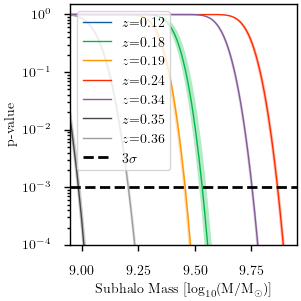

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fontsize = 10
matplotlib.rcParams["font.size"] = fontsize

f, ax = plt.subplots(1, 1, figsize=(3, 3), constrained_layout=True)  # 

# Add inset axes
# ax_inset = ax.inset_axes(bounds=[0.07,0.14,0.2,0.2])  # width="30%", height="30%", loc='upper left'
# ax_inset.set_xlim(9.0, 9.1)
# ax_inset.set_ylim(0.0005, 0.002)
# ax_inset.set_yscale('log')

for result, z in results_to_plot:
    mass_pvals, uplims, lolims = [], [], []
    for mass in tqdm(masses):

        position_pvals, maxes, mins = [], [], []
        for position_key in list(results[0].keys()):
            pvals = result[position_key][str(int(mass))]
            position_pvals.append(np.median(pvals))

        maxes.append(np.max(position_pvals))
        mins.append(np.min(position_pvals))
        mass_pvals.append(np.median(position_pvals))
        uplims.append(np.max(position_pvals))
        lolims.append(np.min(position_pvals))

    ax.plot(np.log10(masses), mass_pvals, label=rf'$z$={z:.2f}', lw=1.)
    ax.fill_between(np.log10(masses), uplims, lolims, alpha=0.3)

    # ax_inset.plot(np.log10(masses), mass_pvals)
    # ax_inset.fill_between(np.log10(masses), uplims, lolims, alpha=0.3)

ax.axhline(pval_threshold, color='black', linestyle='--', label=f'3$\sigma$', zorder=1e3)
# ax_inset.axhline(pval_threshold, color='black', linestyle='--', zorder=1e3)

# ax_inset.set_xticklabels([])
# ax_inset.set_yticklabels([])
# ax_inset.tick_params(left=False, bottom=False)

ax.set_xlabel(r'Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
ax.set_ylabel('p-value')
# plt.xscale('log')
plt.yscale('log')
ax.set_xlim(8.95, 9.95)
ax.set_ylim(10e-5, 1.5e0)
ax.legend(loc='upper left')  # 

for item in ([ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels() + 
              ax.get_legend().get_texts()):
     item.set_fontsize(fontsize)

plt.savefig(os.path.join(figure_dir, 'pvals.png'))
plt.show()

100%|██████████| 288/288 [00:06<00:00, 45.78it/s]


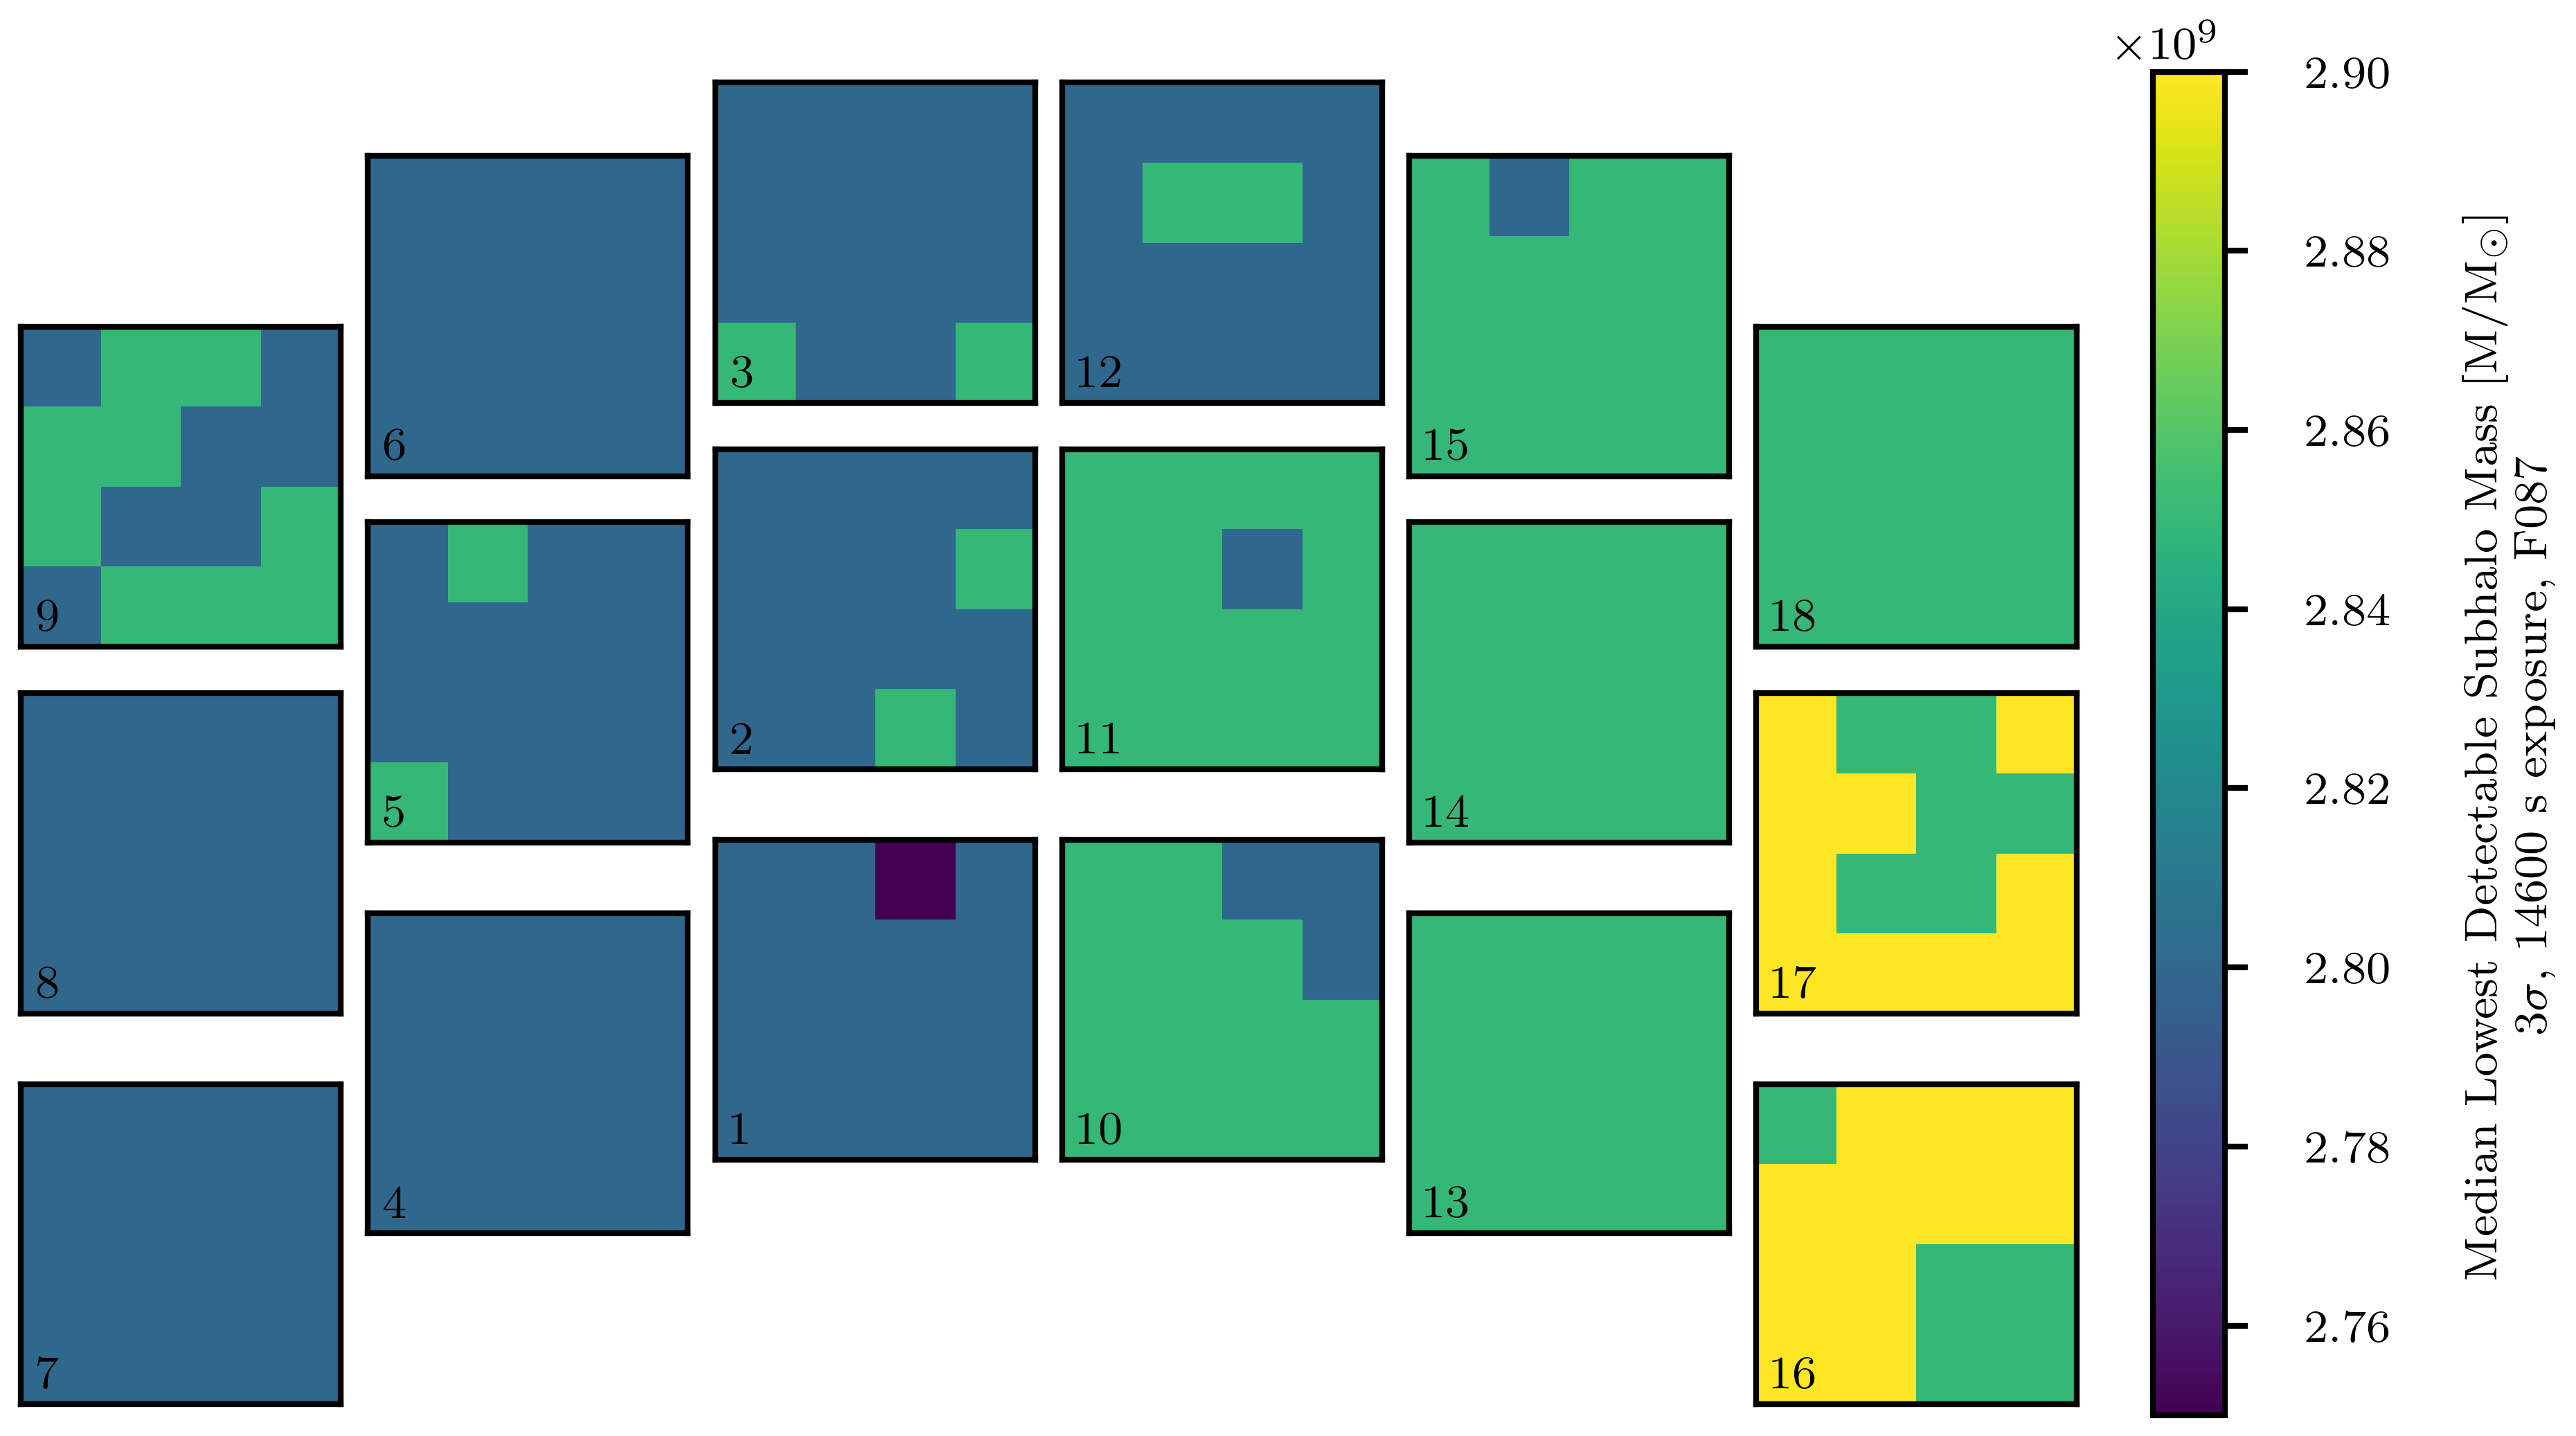

In [21]:
array_list = []

# initialize first array (for SCA 1)
array = np.empty((sides, sides))
medians = []

# loop through positions
for sca, sca_position in tqdm(positions):
    position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'

    lowest_det_masses_at_position = []
    for result in results:
        position_results = result[position_key]

        for mass in masses:
            pvals = position_results[str(int(mass))]
            mass = float(mass)
            if np.min(pvals) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                lowest_det_masses_at_position.append(mass)
                break
    
    assert len(lowest_det_masses_at_position) == len(results), f'Not all results have a detectable mass at position {position_key}'

    median_lowest_det_mass_at_position = np.median(lowest_det_masses_at_position)
    medians.append(median_lowest_det_mass_at_position)

    # if the last position on the SCA has been reached (top-right corner), populate the array with the masses
    if sca_position == roman_util.divide_up_sca(sides)[-1]:  
        assert len(medians) == sides * sides, f'Not all positions have been filled for SCA {sca}'

        for i in range(sides):
            for j in range(sides):
                array[i, j] = medians[j * sides + i]

        array_list.append(array)

        # plt.imshow(array)
        # plt.colorbar()
        # plt.show()

        # reset the array and median list for the next SCA
        array = np.empty((sides, sides))
        medians = []

plotting.roman_sca_plot(np.asarray(array_list), 
                        np.arange(1, 19), 
                        residual_plot=False, 
                        show_sca_id=True, 
                        cmap='viridis', 
                        savefig=True, 
                        savepath=os.path.join(figure_dir, f'lowest_detectable_subhalo_mass.png'), 
                        clabel=r'Median Lowest Detectable Subhalo Mass [M/M$_\odot$]' + '\n3$\sigma$, 14600 s exposure, F087',
                        sca_id_pos=(-0.3, -0.3),
                        fontsize=8)

# f, ax = plt.subplots(3, 6, figsize=(12, 6), constrained_layout=True)
# for i, array in enumerate(array_list):
#     im = ax[i // 6, i % 6].imshow(array, cmap='viridis', vmin=1e9, vmax=4e9)  # vmin=masses[0], vmax=masses[-1]
#     ax[i // 6, i % 6].set_title(f'SCA {i + 1}')
#     ax[i // 6, i % 6].axis('off')
# cbar = f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label(r'Median Lowest Detectable Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
# plt.show()

100%|██████████| 288/288 [00:06<00:00, 43.55it/s]


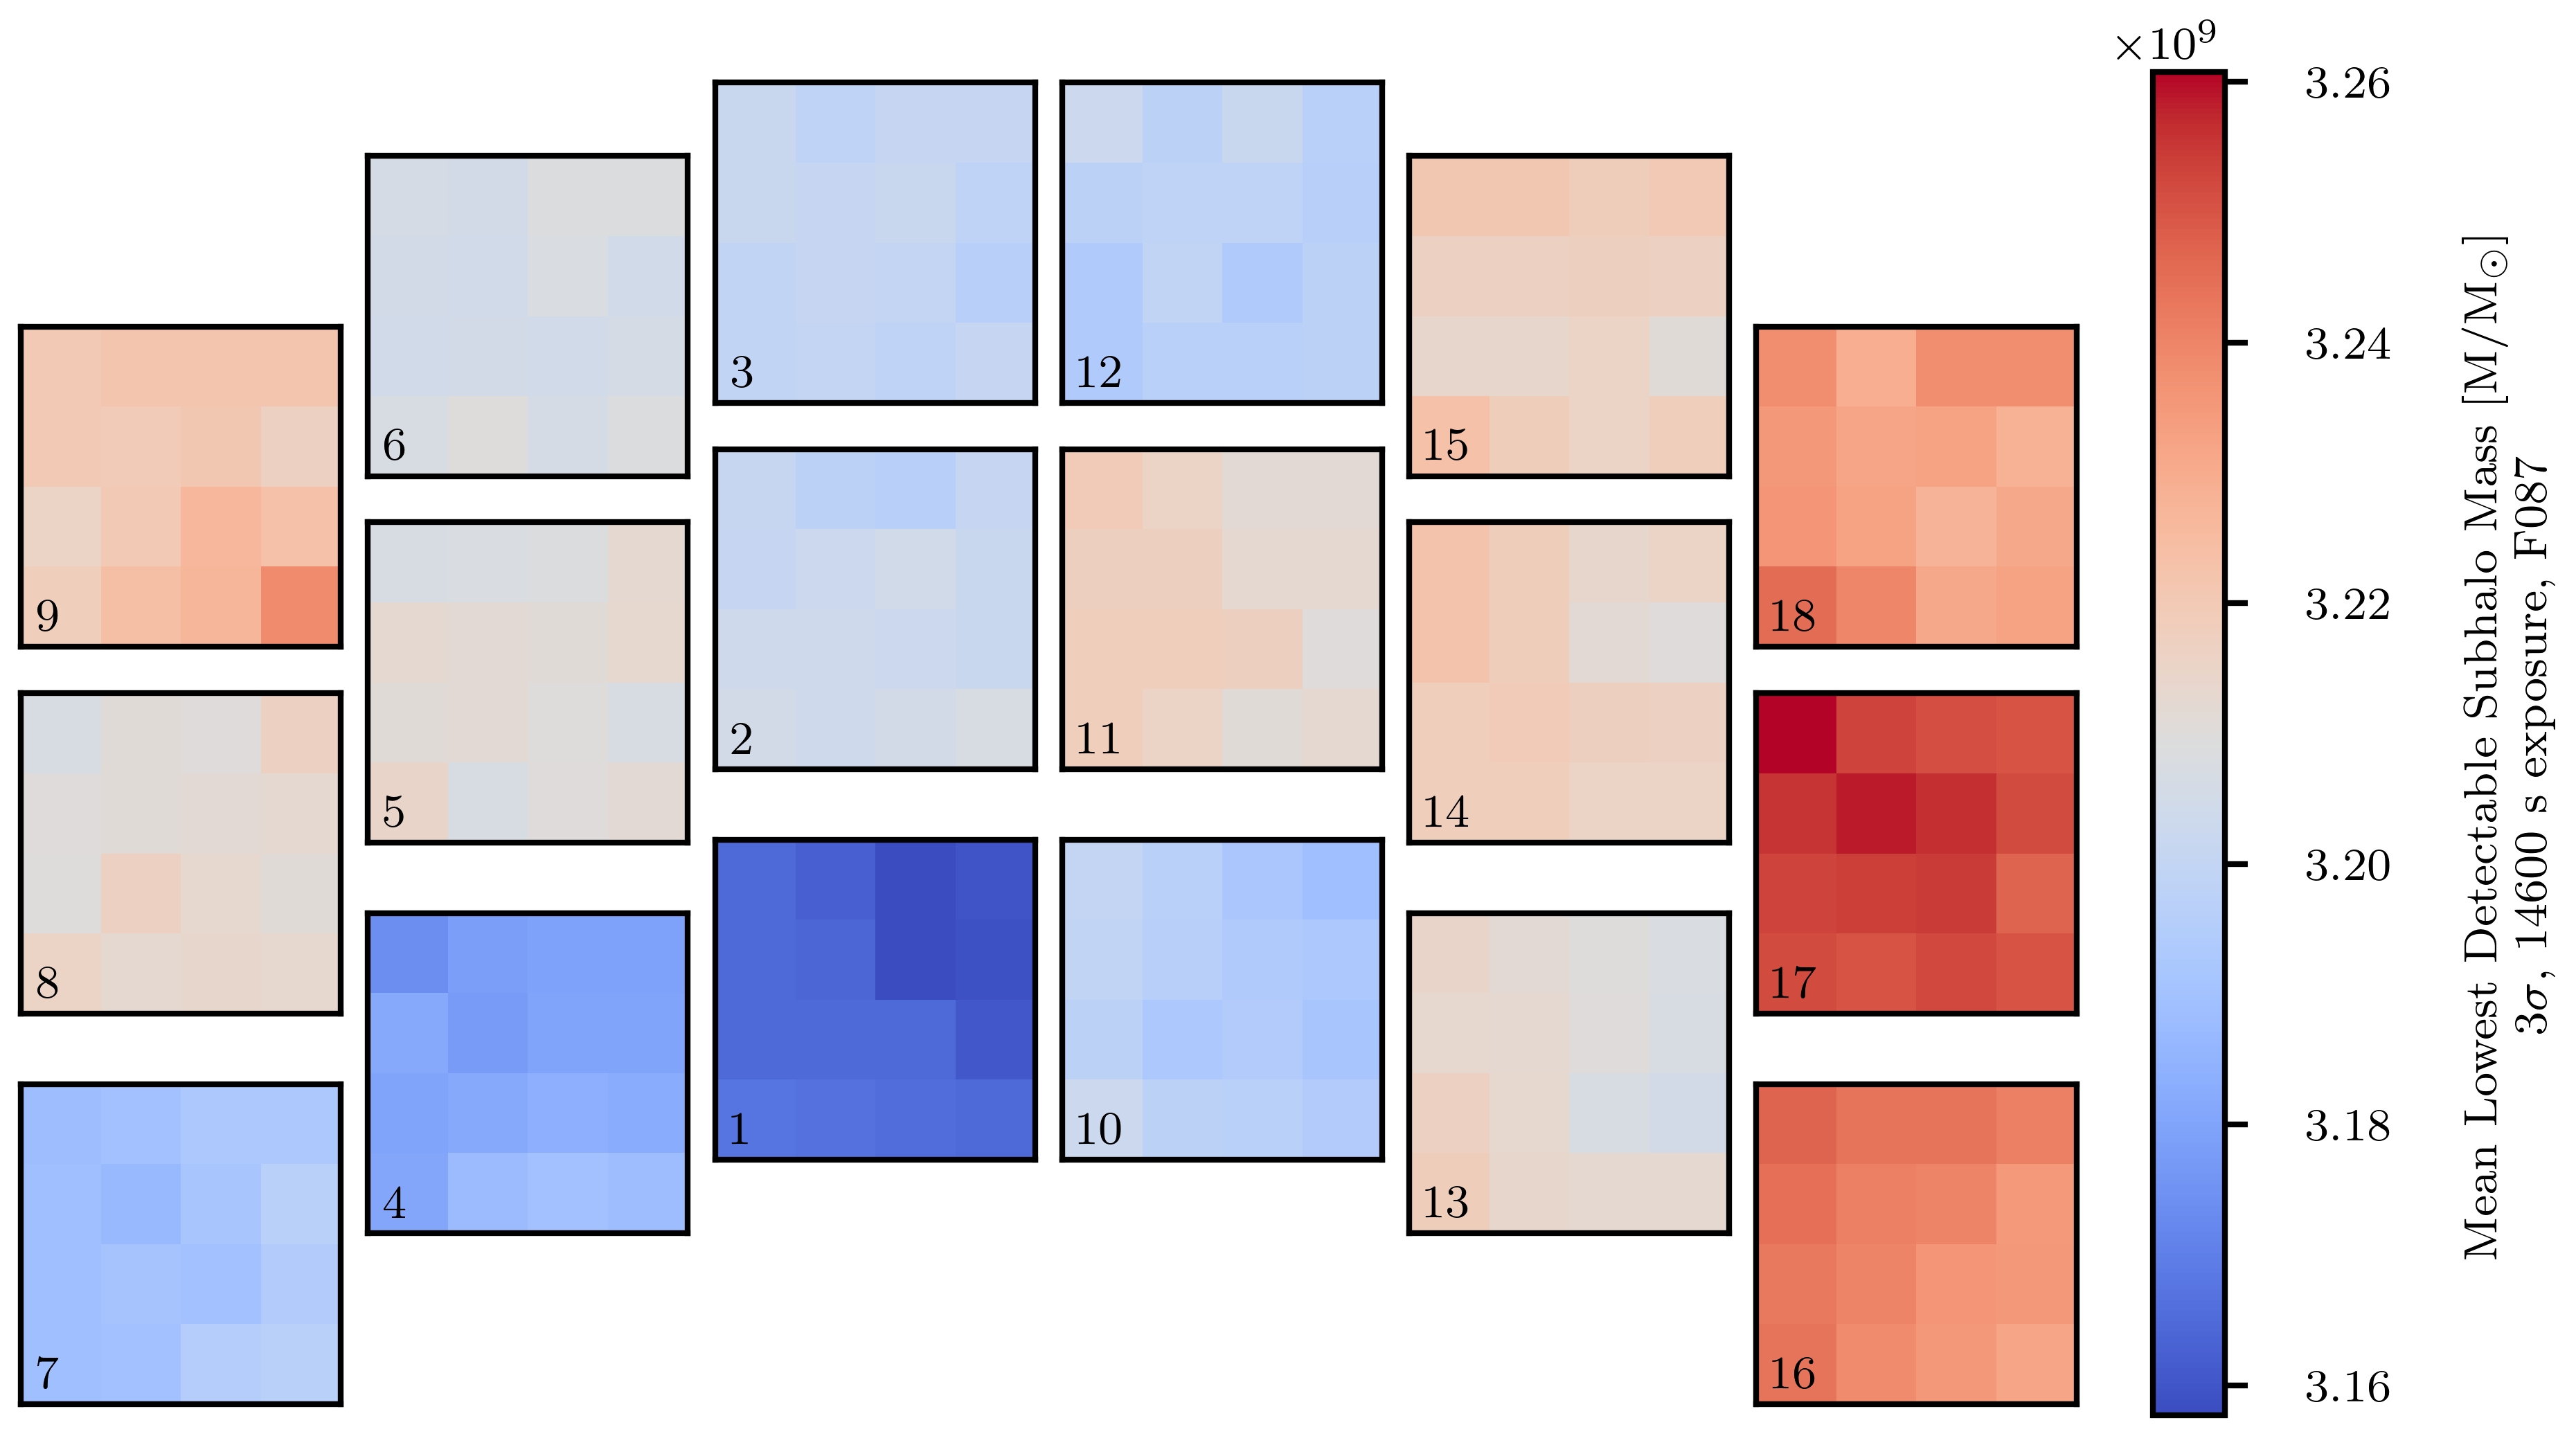

In [35]:
array_list = []

# initialize first array (for SCA 1)
array = np.empty((sides, sides))
means = []

# loop through positions
for sca, sca_position in tqdm(positions):
    position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'

    lowest_det_masses_at_position = []
    for result in results:
        position_results = result[position_key]

        for mass in masses:
            pvals = position_results[str(int(mass))]
            mass = float(mass)
            if np.min(pvals) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                lowest_det_masses_at_position.append(mass)
                break
    
    assert len(lowest_det_masses_at_position) == len(results), f'Not all results have a detectable mass at position {position_key}'

    mean_lowest_det_mass_at_position = np.mean(lowest_det_masses_at_position)
    means.append(mean_lowest_det_mass_at_position)

    # if the last position on the SCA has been reached (top-right corner), populate the array with the masses
    if sca_position == roman_util.divide_up_sca(sides)[-1]:  
        assert len(means) == sides * sides, f'Not all positions have been filled for SCA {sca}'

        for i in range(sides):
            for j in range(sides):
                array[i, j] = means[j * sides + i]

        array_list.append(array)

        # plt.imshow(array)
        # plt.colorbar()
        # plt.show()

        # reset the array and median list for the next SCA
        array = np.empty((sides, sides))
        means = []

fontsize = 14
matplotlib.rcParams["font.size"] = fontsize

plotting.roman_sca_plot(np.asarray(array_list), 
                        np.arange(1, 19), 
                        residual_plot=False, 
                        show_sca_id=True, 
                        cmap='coolwarm', 
                        savefig=True, 
                        savepath=os.path.join(figure_dir, f'lowest_detectable_subhalo_mass_mean.png'), 
                        clabel=r'Mean Lowest Detectable Subhalo Mass [M/M$_\odot$]' + '\n3$\sigma$, 14600 s exposure, F087',
                        sca_id_pos=(-0.3, -0.3),
                        fontsize=8)

# f, ax = plt.subplots(3, 6, figsize=(12, 6), constrained_layout=True)
# for i, array in enumerate(array_list):
#     im = ax[i // 6, i % 6].imshow(array, cmap='viridis', vmin=3.48e9, vmax=3.65e9)  # vmin=masses[0], vmax=masses[-1]
#     ax[i // 6, i % 6].set_title(f'SCA {i + 1}')
#     ax[i // 6, i % 6].axis('off')
# cbar = f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label(r'Mean Lowest Detectable Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
# plt.show()

In [23]:
# array_list = [i * np.ones((4, 4)) for i in range(1, 19)]

# assert not util.all_arrays_equal(array_list), 'All SCAs have the same detectable mass array'

In [24]:
# for sample_result in results[:10]:
#     array_list = []
#     array = np.empty((sides, sides))
#     lowest_det_mass_at_position = []

#     for sca, sca_position in tqdm(positions):
#         position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
#         position_results = sample_result[position_key]

#         for mass in masses:
#             pvals = position_results[str(int(mass))]
#             mass = float(mass)
#             if np.min(pvals) < pval_threshold:
#                 # print(f'hit threshold at {mass:.2e}')
#                 lowest_det_mass_at_position.append(mass)
#                 break

#         # if the last position on the SCA has been reached (top-right corner), populate the array with the masses
#         if sca_position == roman_util.divide_up_sca(sides)[-1]:  
#             for i in range(sides):
#                 for j in range(sides):
#                     array[i, j] = np.log10(lowest_det_mass_at_position[j * sides + i])

#             array_list.append(array)

#             # reset the array and median list for the next SCA
#             array = np.empty((sides, sides))
#             lowest_det_mass_at_position = []

#     # plotting.roman_sca_plot(np.asarray(array_list), 
#     #                         np.arange(1, 19), 
#     #                         residual_plot=False, 
#     #                         show_sca_id=True, 
#     #                         cmap='viridis_r', 
#     #                         savefig=False, 
#     #                         clabel=r'Lowest detectable subhalo mass [$\log_{10}$(M$_\odot$)]',
#     #                         sca_id_pos=(0,0))

#     vmin, vmax = plot_util.get_min_max(array_list)
#     f, ax = plt.subplots(3, 6, figsize=(12, 6), constrained_layout=True)
#     for i, array in enumerate(array_list):
#         im = ax[i // 6, i % 6].imshow(array, cmap='viridis', vmin=vmin, vmax=vmax)  # , vmin=np.log10(masses[0]), vmax=np.log10(masses[-1])
#         ax[i // 6, i % 6].set_title(f'SCA {i + 1}')
#         ax[i // 6, i % 6].axis('off')
#     cbar = f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
#     cbar.set_label(r'Mean Lowest Detectable Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
#     plt.show()

In [25]:
spreads = []
percent_dif = []
max_spread_results = []
max_spread_idx = []

for i, result in tqdm(enumerate(results), total=len(results)):
    array_list = []
    array = np.empty((sides, sides))
    lowest_det_mass_at_position = []

    for sca, sca_position in positions:
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = result[position_key]

        for mass in masses:
            pvals = position_results[str(int(mass))]
            mass = float(mass)
            if np.min(pvals) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                lowest_det_mass_at_position.append(mass)
                break

        # if the last position on the SCA has been reached (top-right corner), populate the array with the masses
        if sca_position == roman_util.divide_up_sca(sides)[-1]:  
            for i in range(sides):
                for j in range(sides):
                    array[i, j] = lowest_det_mass_at_position[j * sides + i]

            array_list.append(array)

            # reset the array and median list for the next SCA
            array = np.empty((sides, sides))
            lowest_det_mass_at_position = []

    spread = np.max(array_list) - np.min(array_list)
    spreads.append(spread)

    dif = util.percent_difference(np.max(array_list), np.min(array_list))
    percent_dif.append(dif)

    if spread > 2e8:
        max_spread_results.append(result)
        max_spread_idx.append(i)

100%|██████████| 65/65 [00:06<00:00, 10.28it/s]


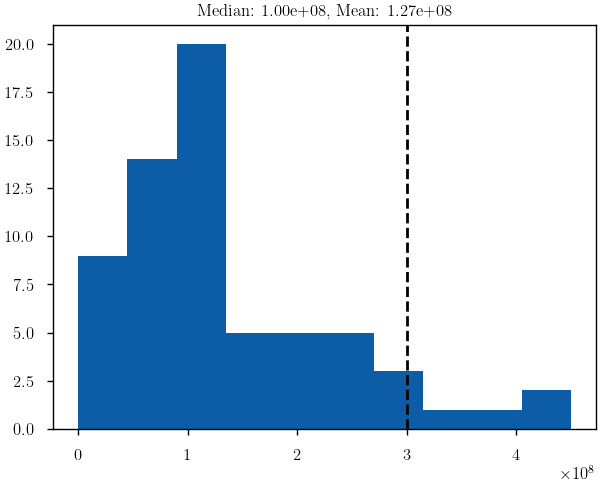

In [26]:
plt.hist(spreads)
plt.axvline(3e8, color='black', linestyle='--')
plt.title(f'Median: {np.median(spreads):.2e}, Mean: {np.mean(spreads):.2e}')
plt.show()

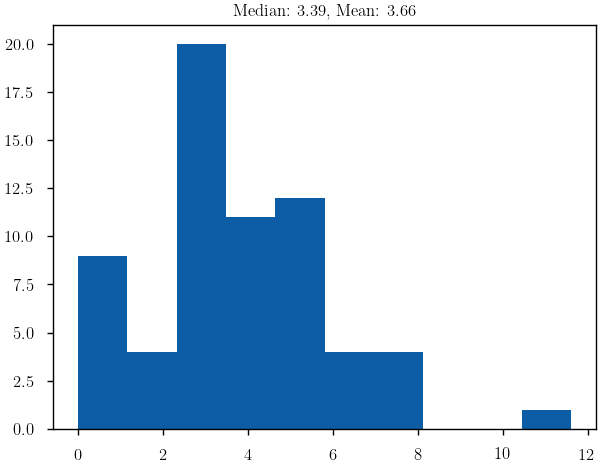

In [27]:
plt.hist(percent_dif)
plt.title(f'Median: {np.median(percent_dif):.2f}, Mean: {np.mean(percent_dif):.2f}')
plt.show()

100%|██████████| 288/288 [00:02<00:00, 127.08it/s]


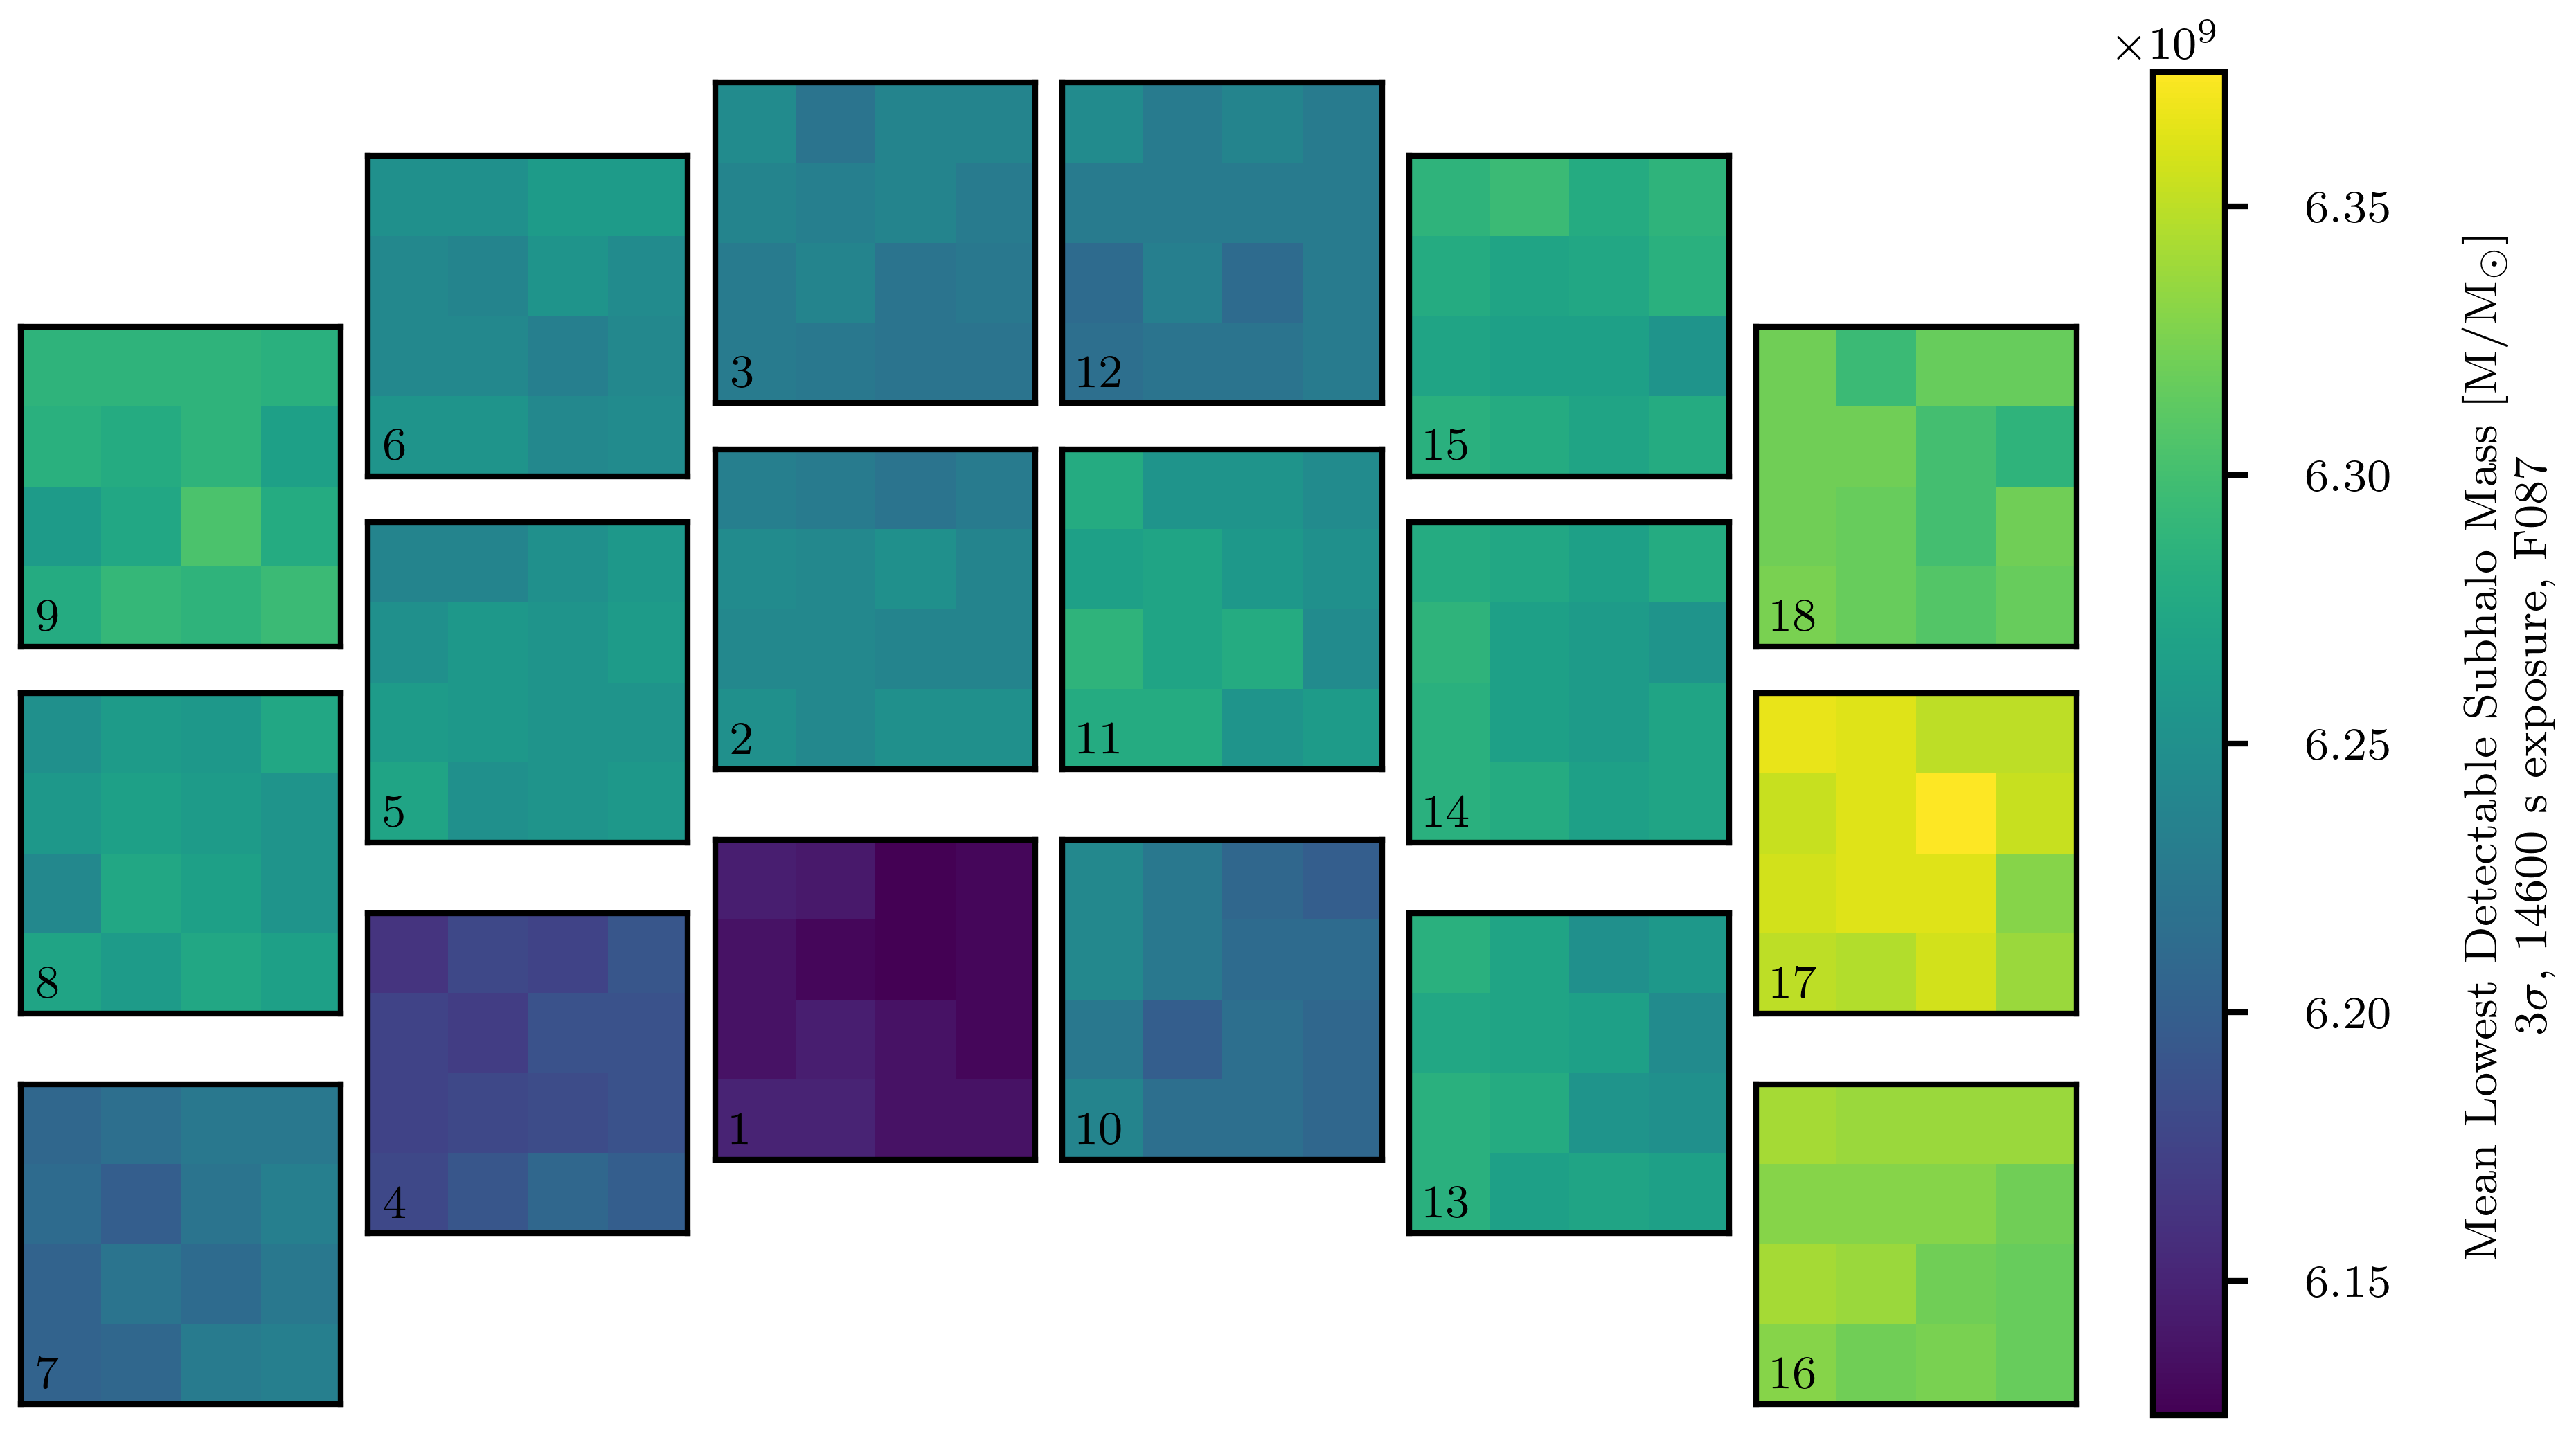

In [28]:
array_list = []

# initialize first array (for SCA 1)
array = np.empty((sides, sides))
means = []

# loop through positions
for sca, sca_position in tqdm(positions):
    position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'

    lowest_det_masses_at_position = []
    for result in max_spread_results:
        position_results = result[position_key]

        for mass in masses:
            pvals = position_results[str(int(mass))]
            mass = float(mass)
            if np.min(pvals) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                lowest_det_masses_at_position.append(mass)
                break
    
    assert len(lowest_det_masses_at_position) == len(max_spread_results), f'Not all results have a detectable mass at position {position_key}'

    mean_lowest_det_mass_at_position = np.mean(lowest_det_masses_at_position)
    means.append(mean_lowest_det_mass_at_position)

    # if the last position on the SCA has been reached (top-right corner), populate the array with the masses
    if sca_position == roman_util.divide_up_sca(sides)[-1]:  
        assert len(means) == sides * sides, f'Not all positions have been filled for SCA {sca}'

        for i in range(sides):
            for j in range(sides):
                array[i, j] = means[j * sides + i]

        array_list.append(array)

        # plt.imshow(array)
        # plt.colorbar()
        # plt.show()

        # reset the array and median list for the next SCA
        array = np.empty((sides, sides))
        means = []

plotting.roman_sca_plot(np.asarray(array_list), 
                        np.arange(1, 19), 
                        residual_plot=False, 
                        show_sca_id=True, 
                        cmap='viridis', 
                        savefig=True, 
                        savepath=os.path.join(figure_dir, f'lowest_detectable_subhalo_mass_max.png'), 
                        clabel=r'Mean Lowest Detectable Subhalo Mass [M/M$_\odot$]' + '\n3$\sigma$, 14600 s exposure, F087',
                        sca_id_pos=(-0.3, -0.3),
                        fontsize=8)

# f, ax = plt.subplots(3, 6, figsize=(12, 6), constrained_layout=True)
# for i, array in enumerate(array_list):
#     im = ax[i // 6, i % 6].imshow(array, cmap='viridis', vmin=3.48e9, vmax=3.65e9)  # vmin=masses[0], vmax=masses[-1]
#     ax[i // 6, i % 6].set_title(f'SCA {i + 1}')
#     ax[i // 6, i % 6].axis('off')
# cbar = f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
# cbar.set_label(r'Mean Lowest Detectable Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
# plt.show()

100%|██████████| 288/288 [00:00<00:00, 3938.78it/s]


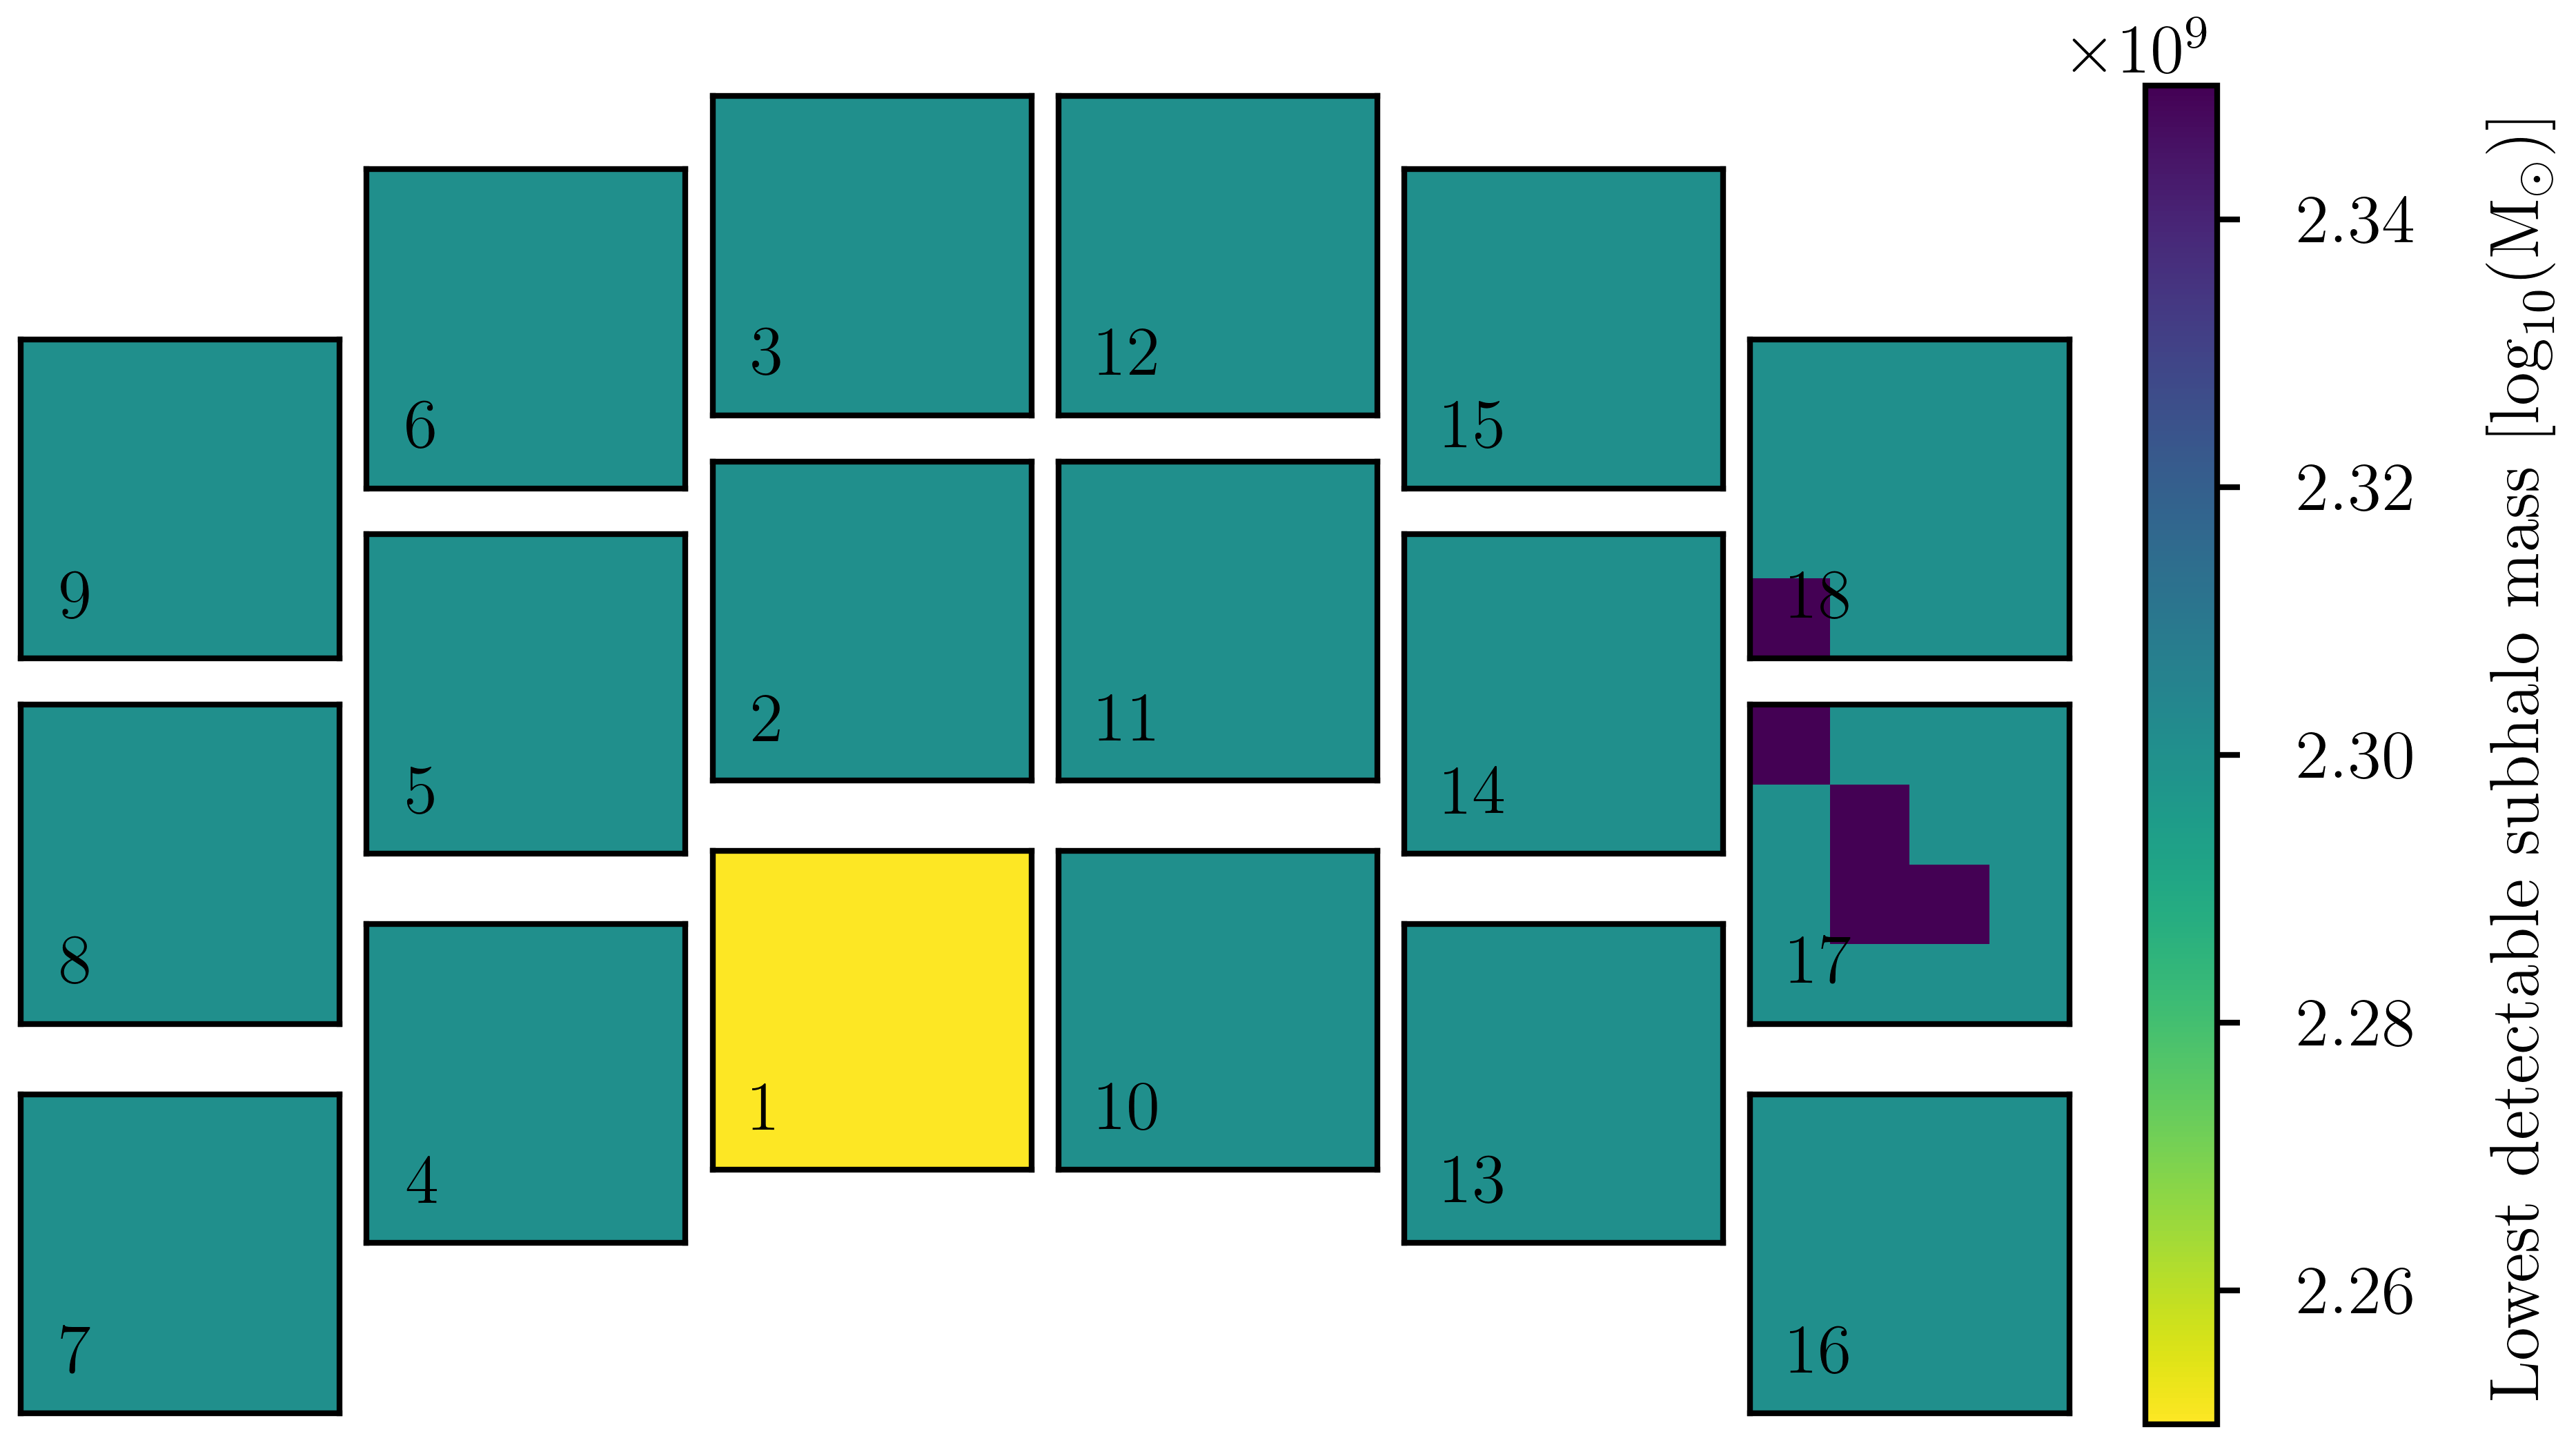

100%|██████████| 288/288 [00:00<00:00, 2334.23it/s]


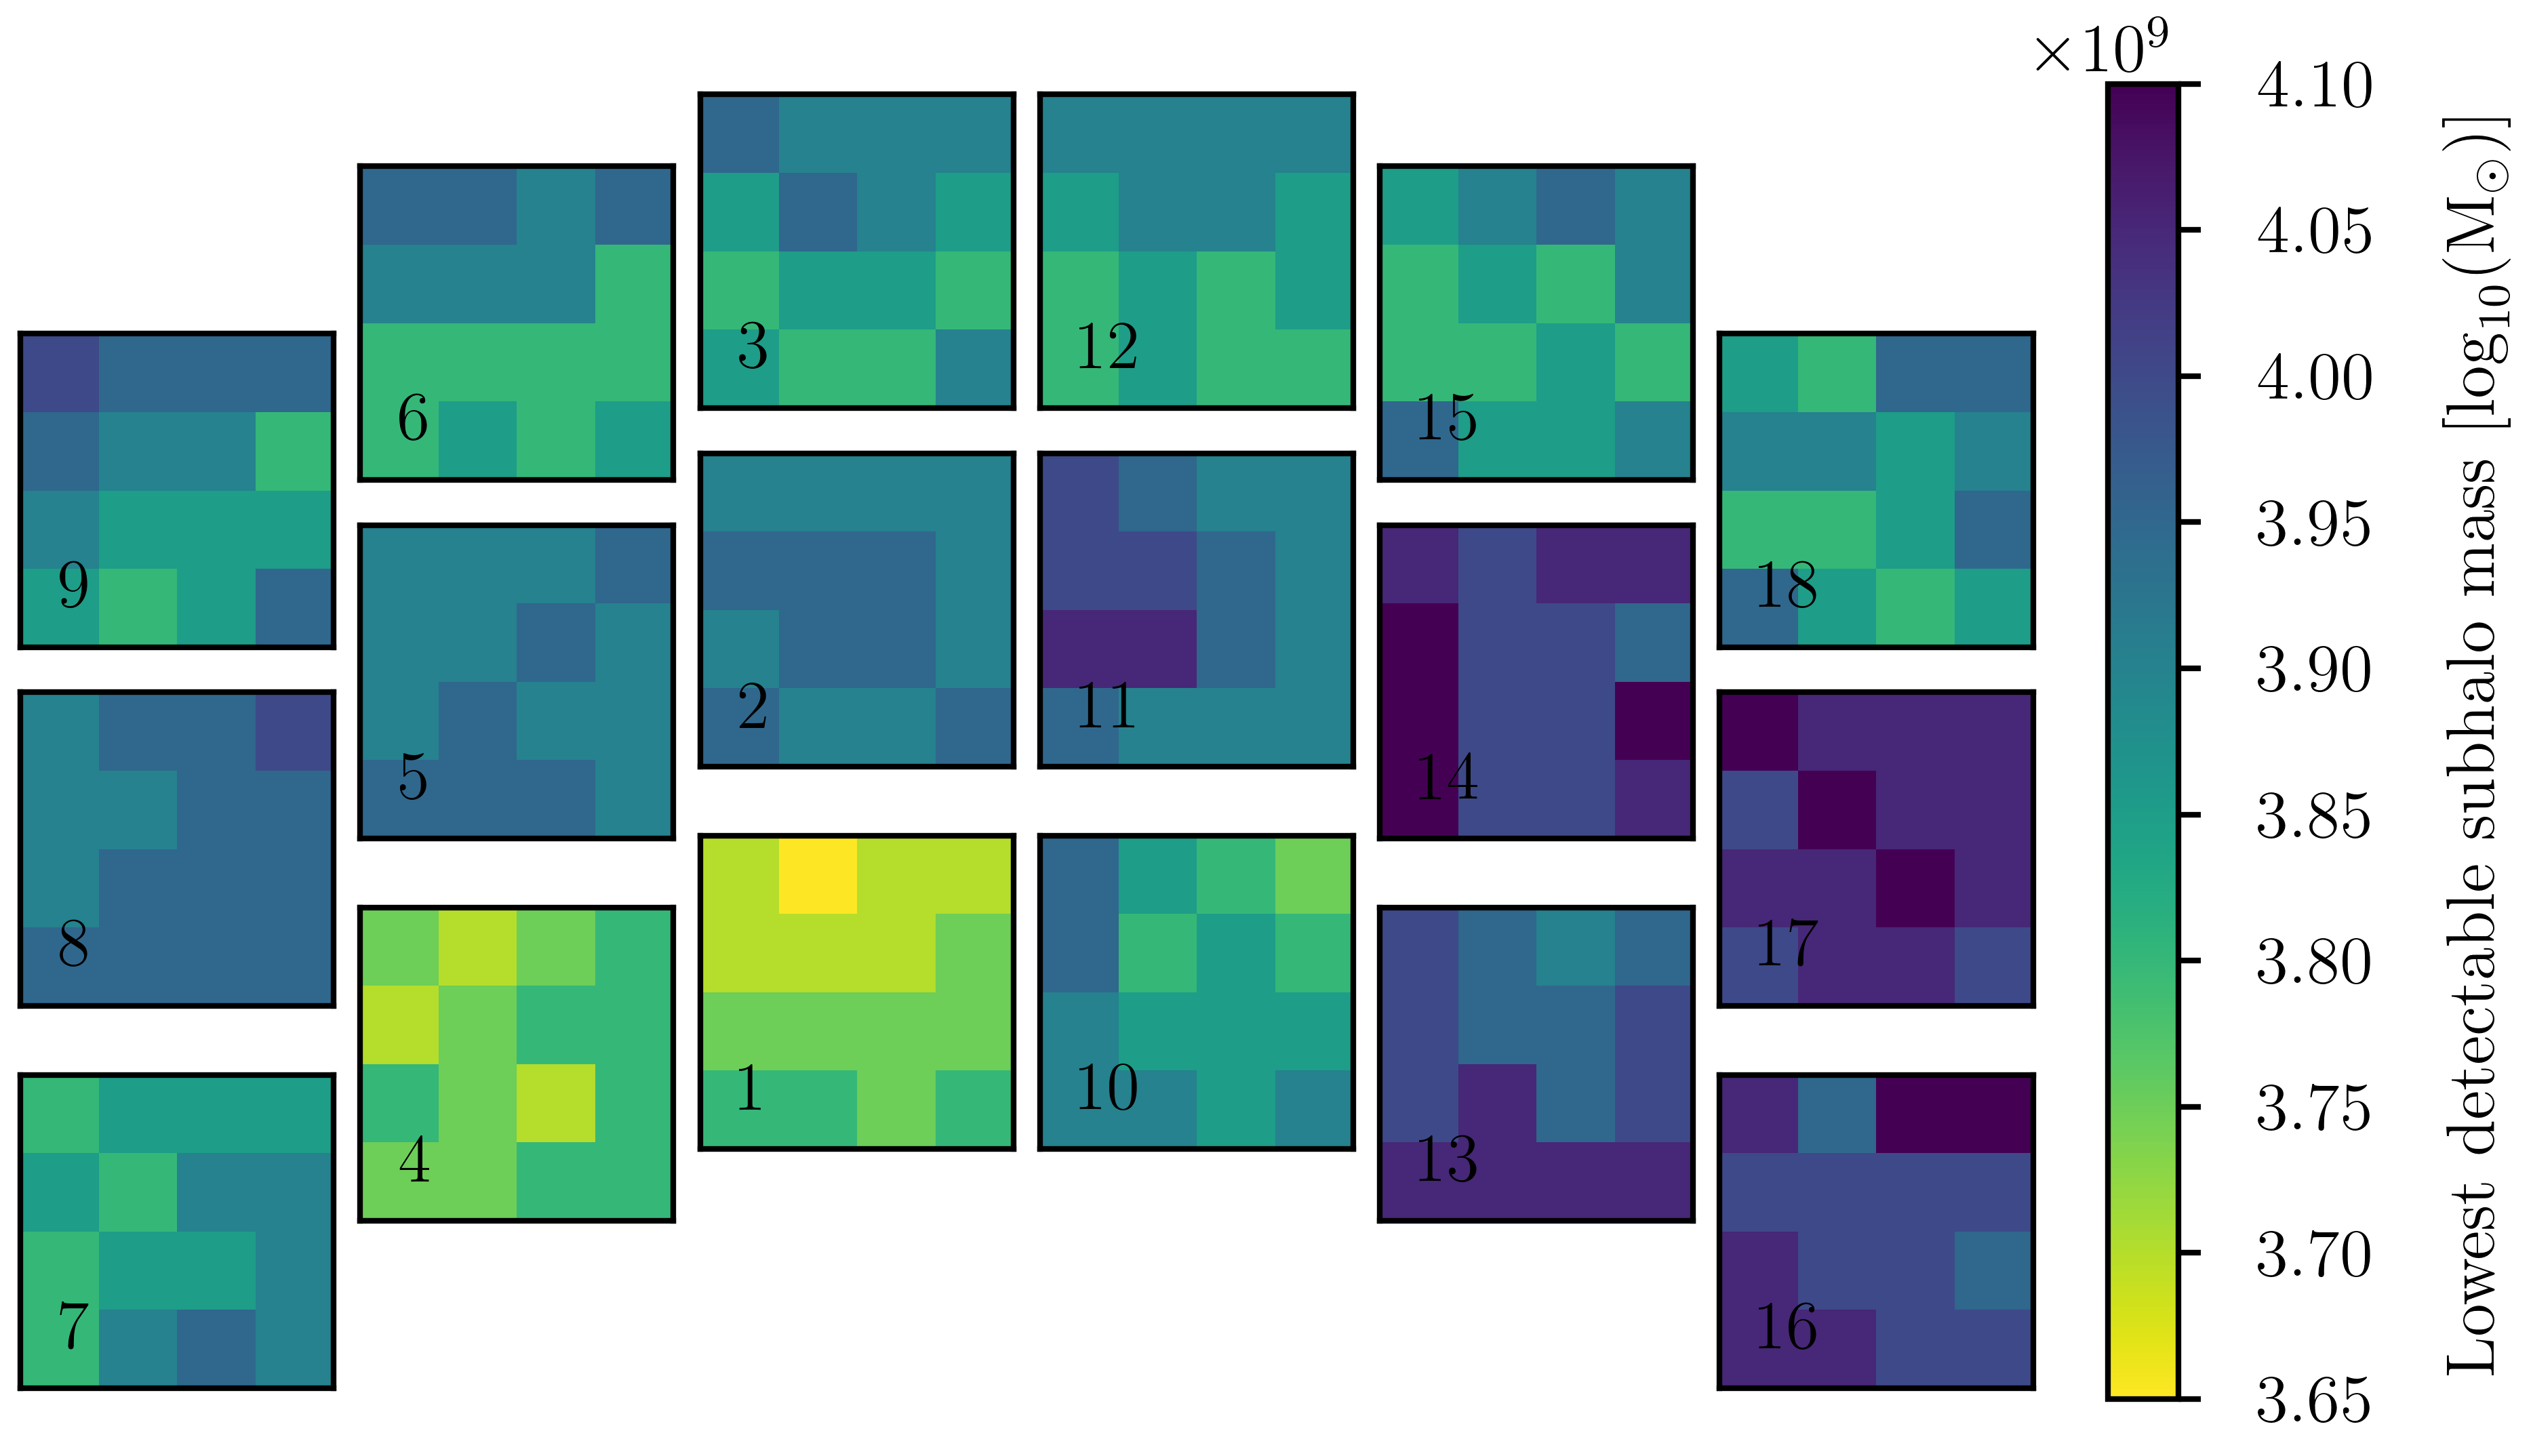

100%|██████████| 288/288 [00:00<00:00, 5886.97it/s]


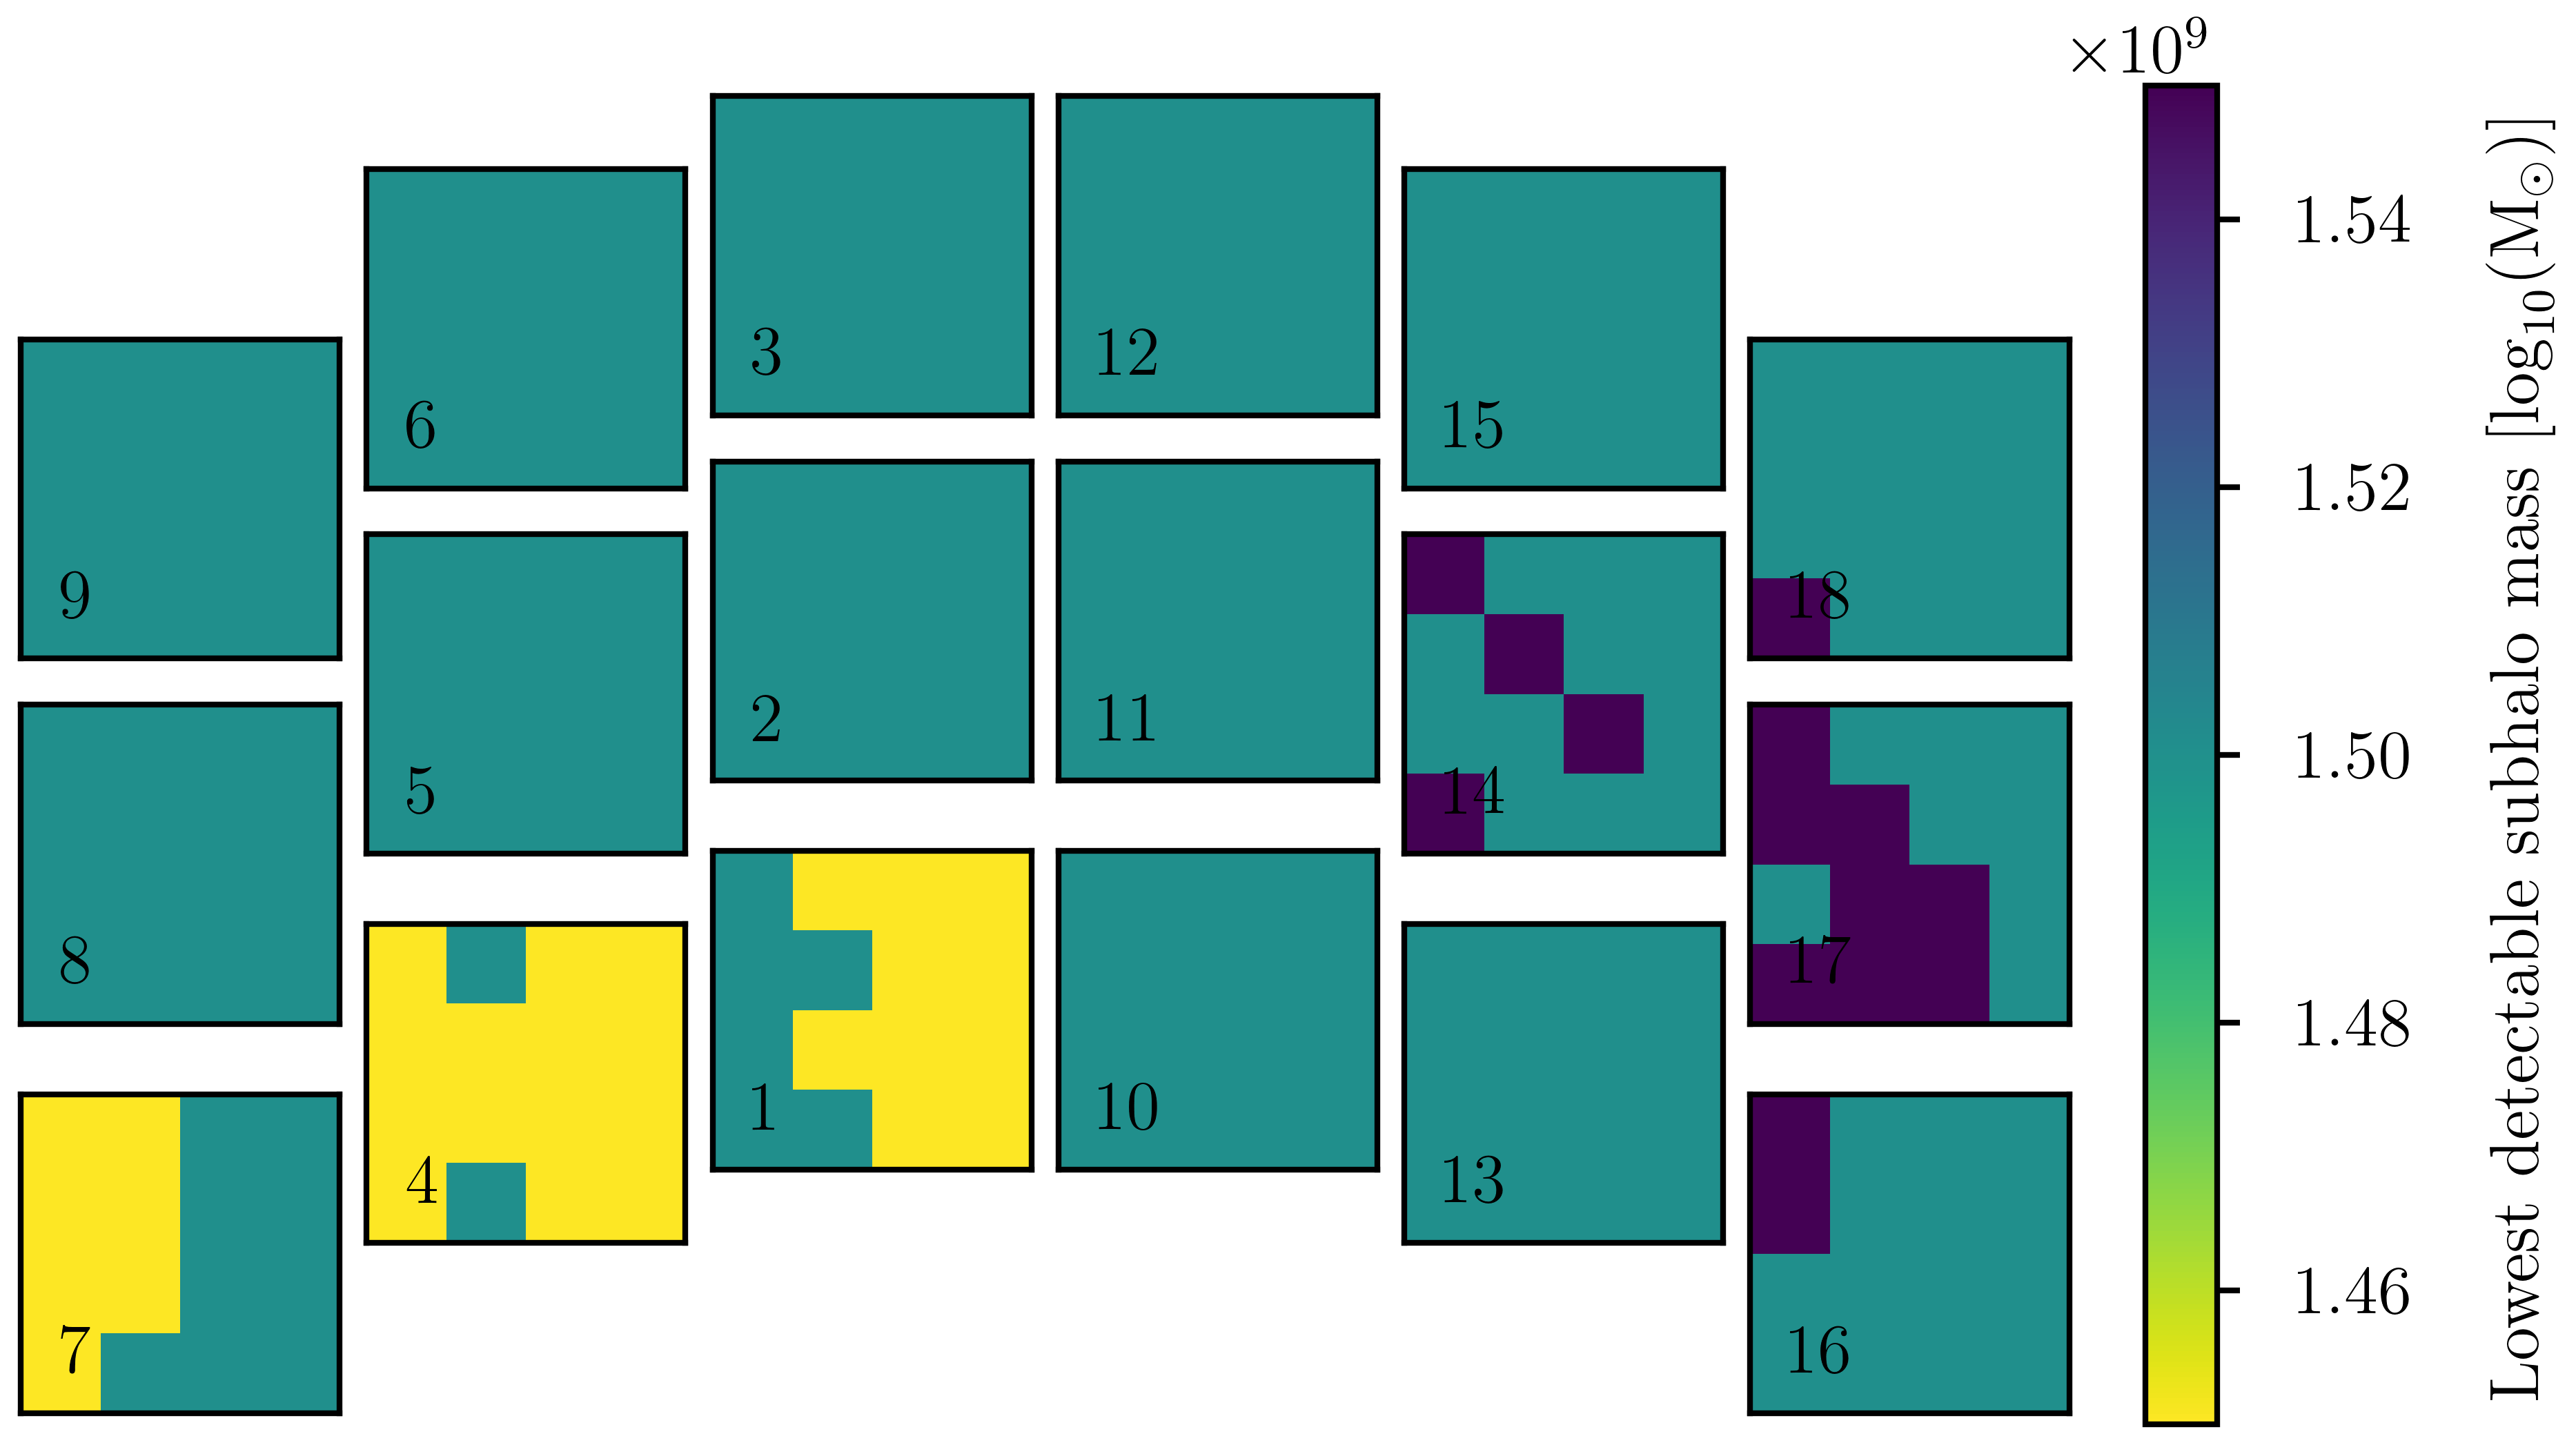

100%|██████████| 288/288 [00:00<00:00, 19362.05it/s]


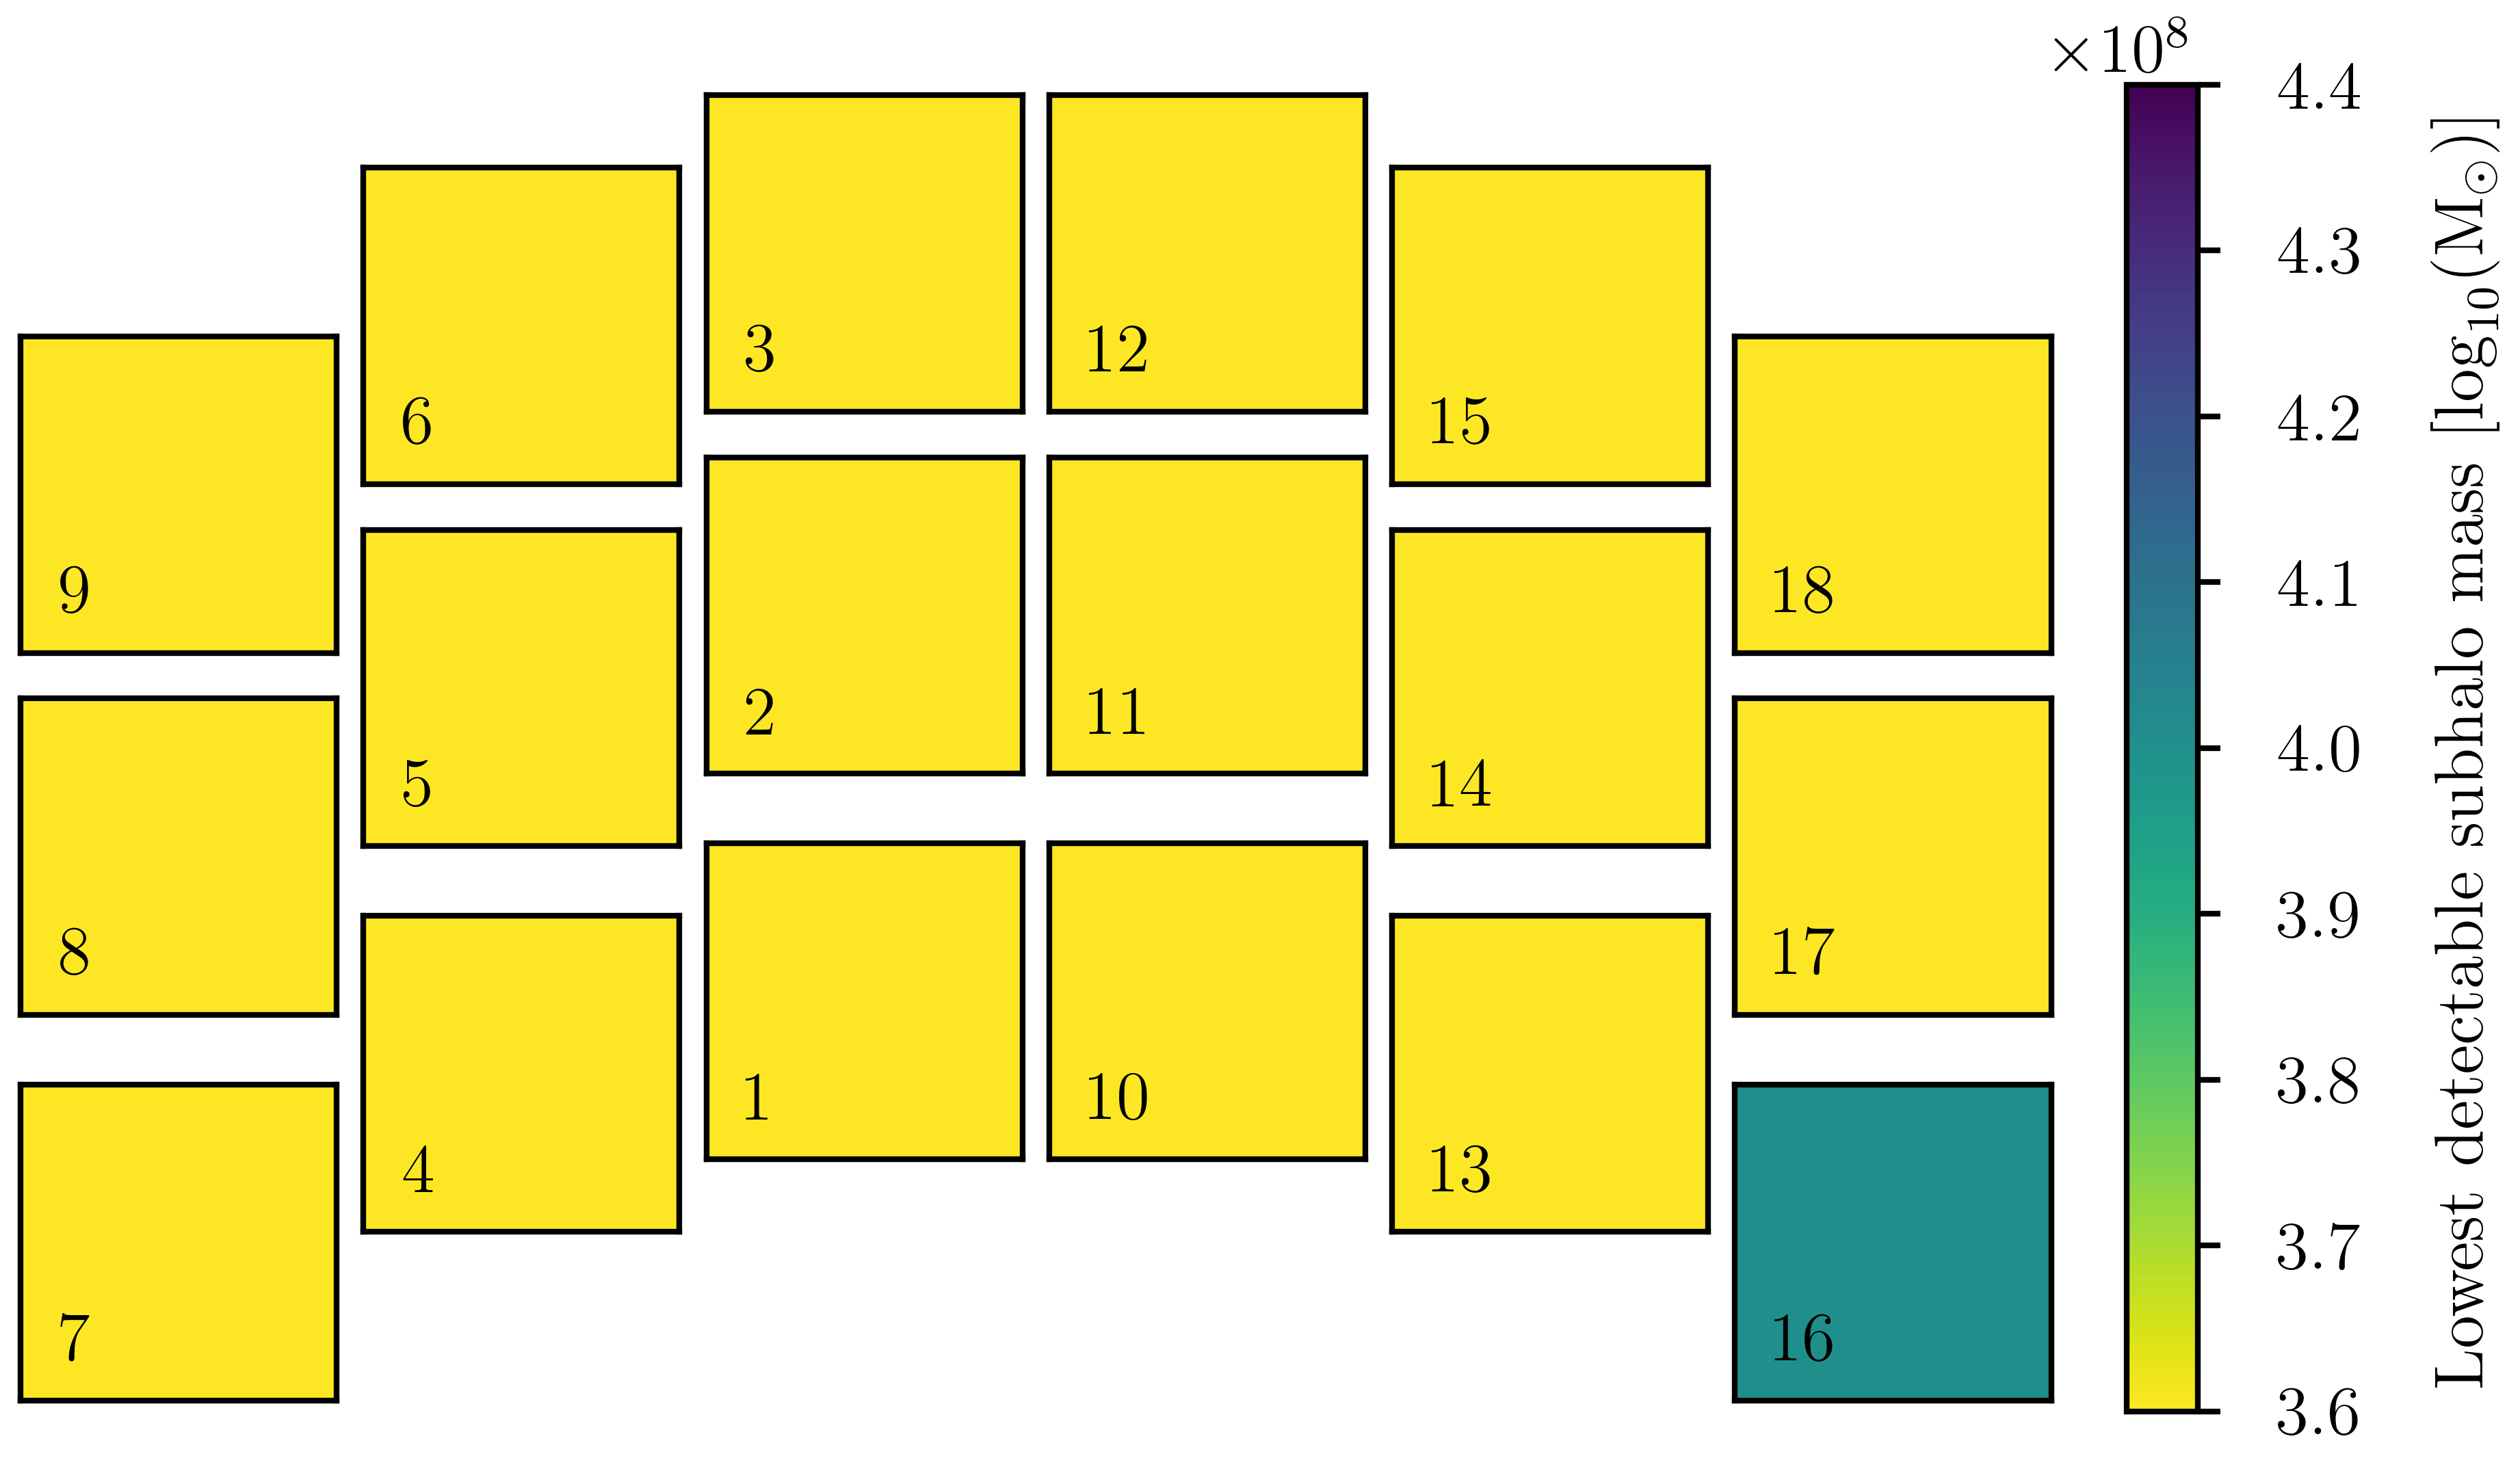

100%|██████████| 288/288 [00:00<00:00, 3687.00it/s]


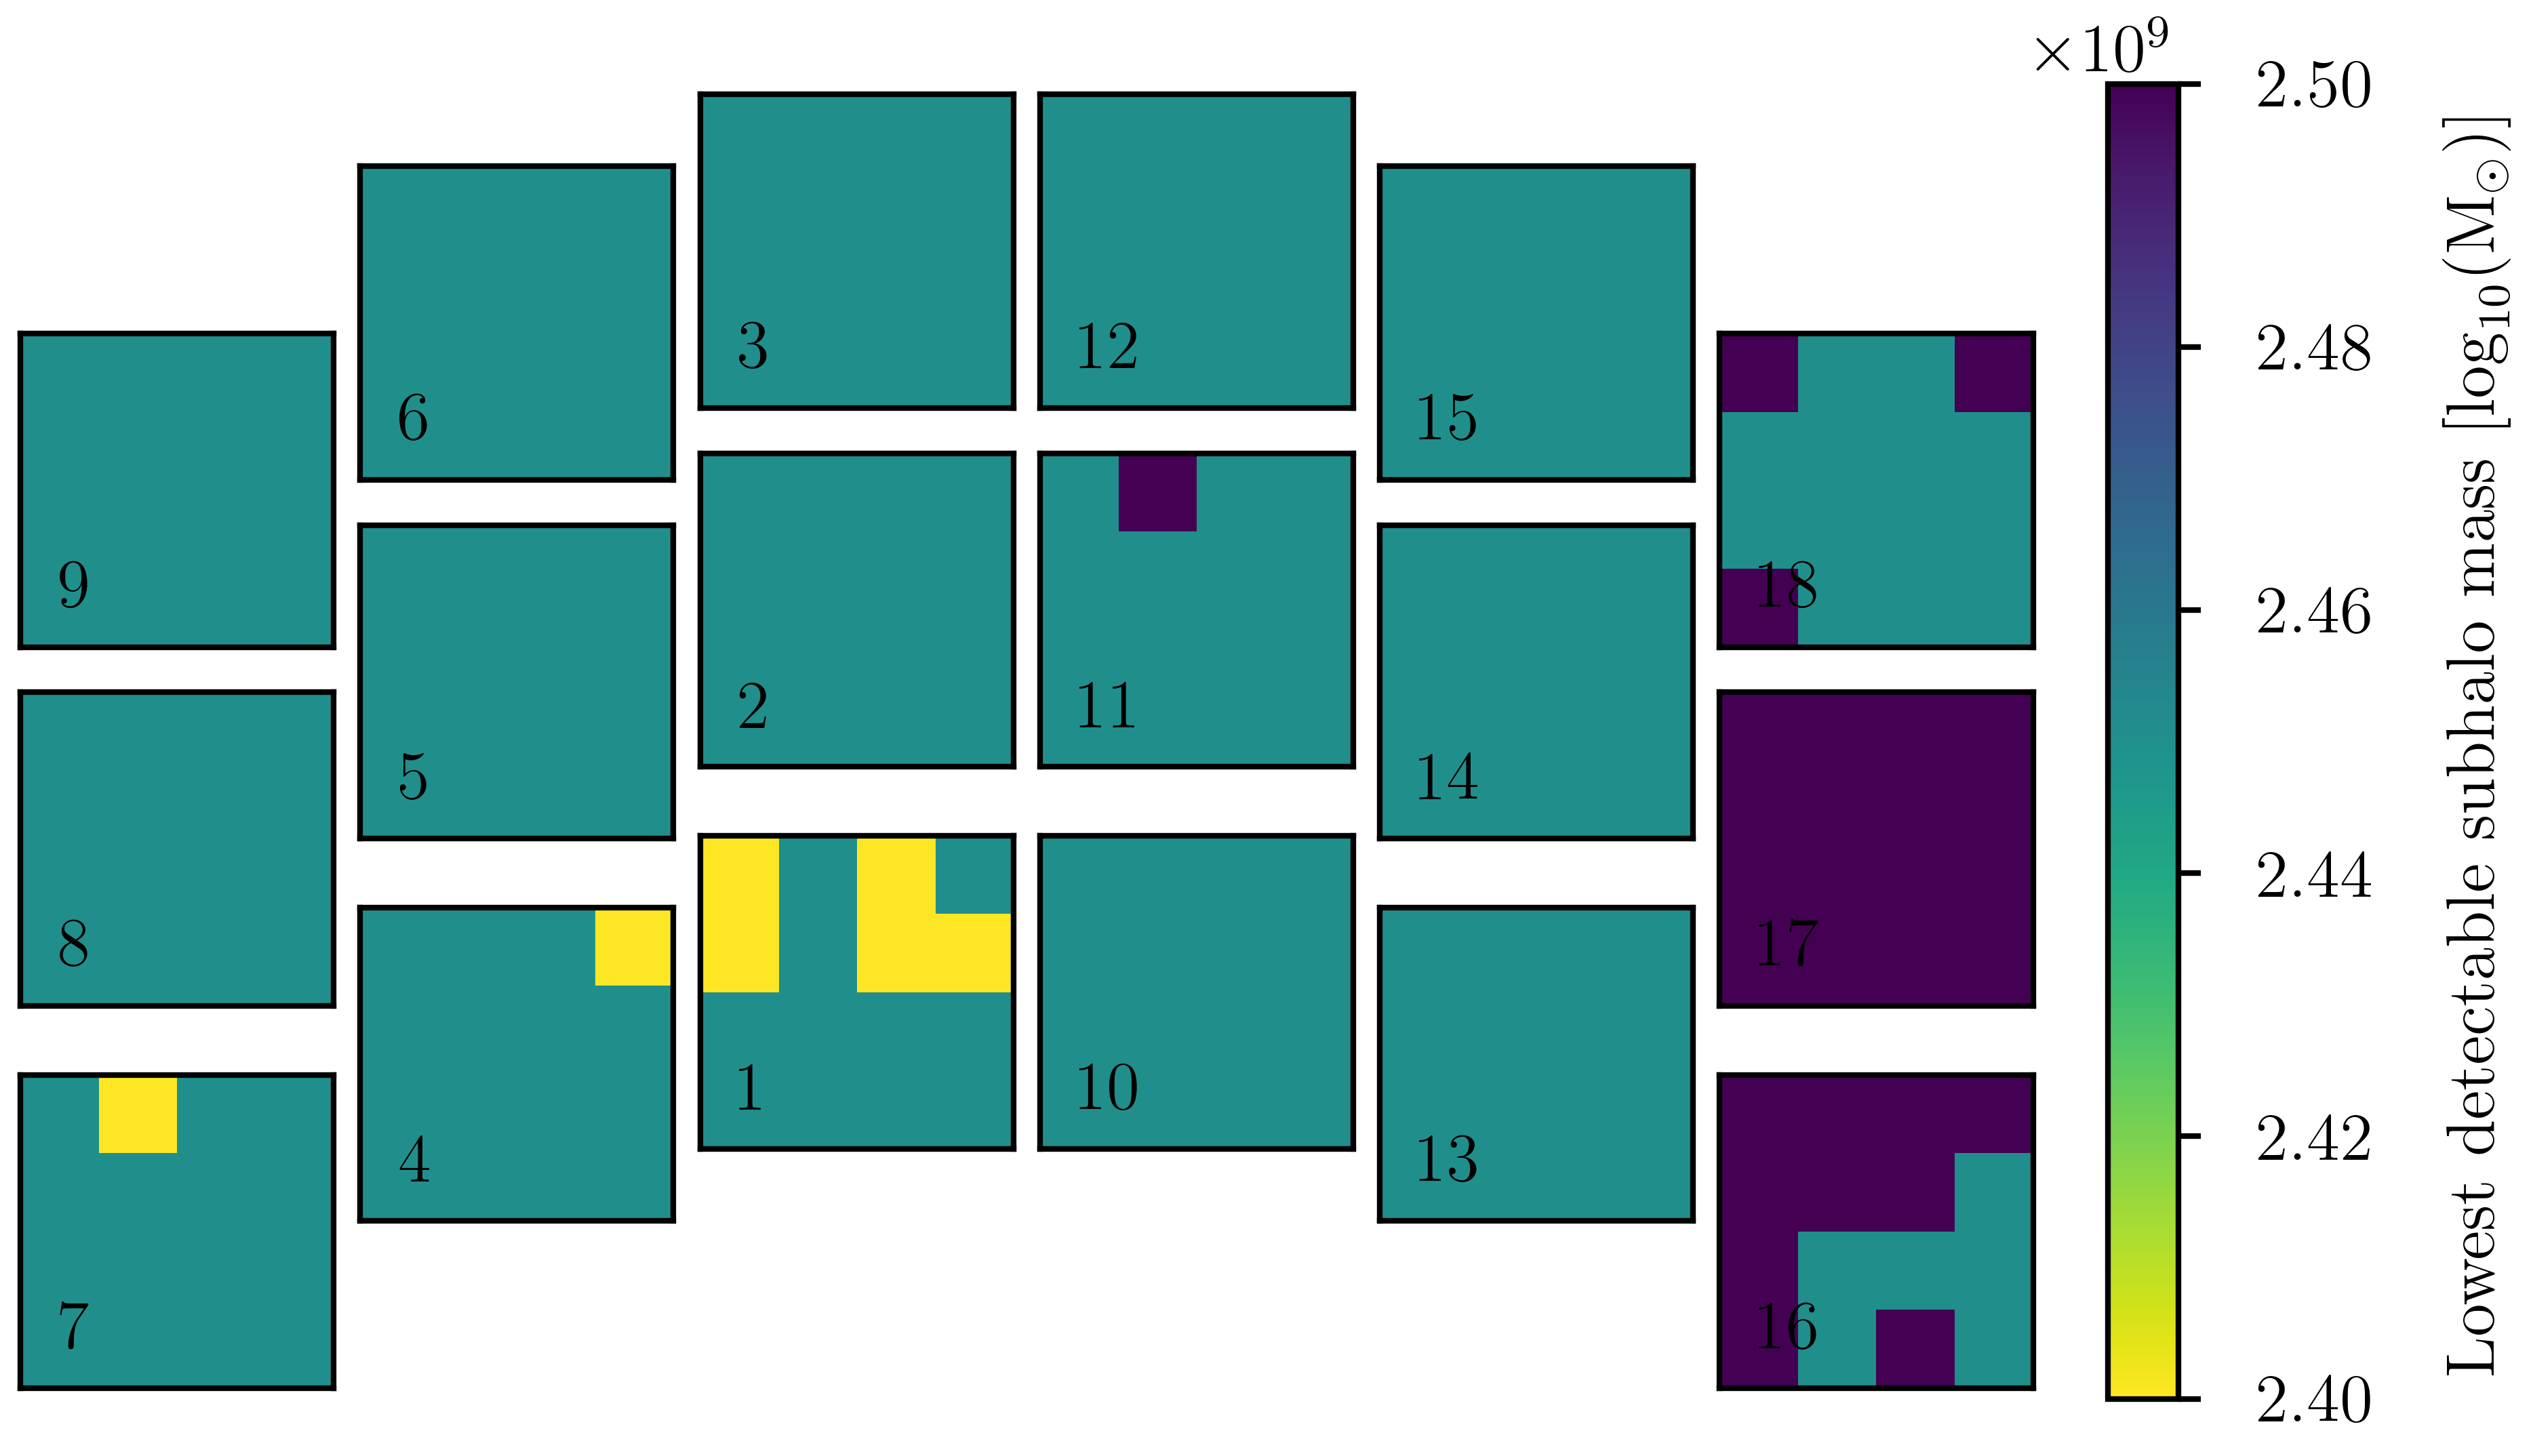

100%|██████████| 288/288 [00:00<00:00, 1170.49it/s]


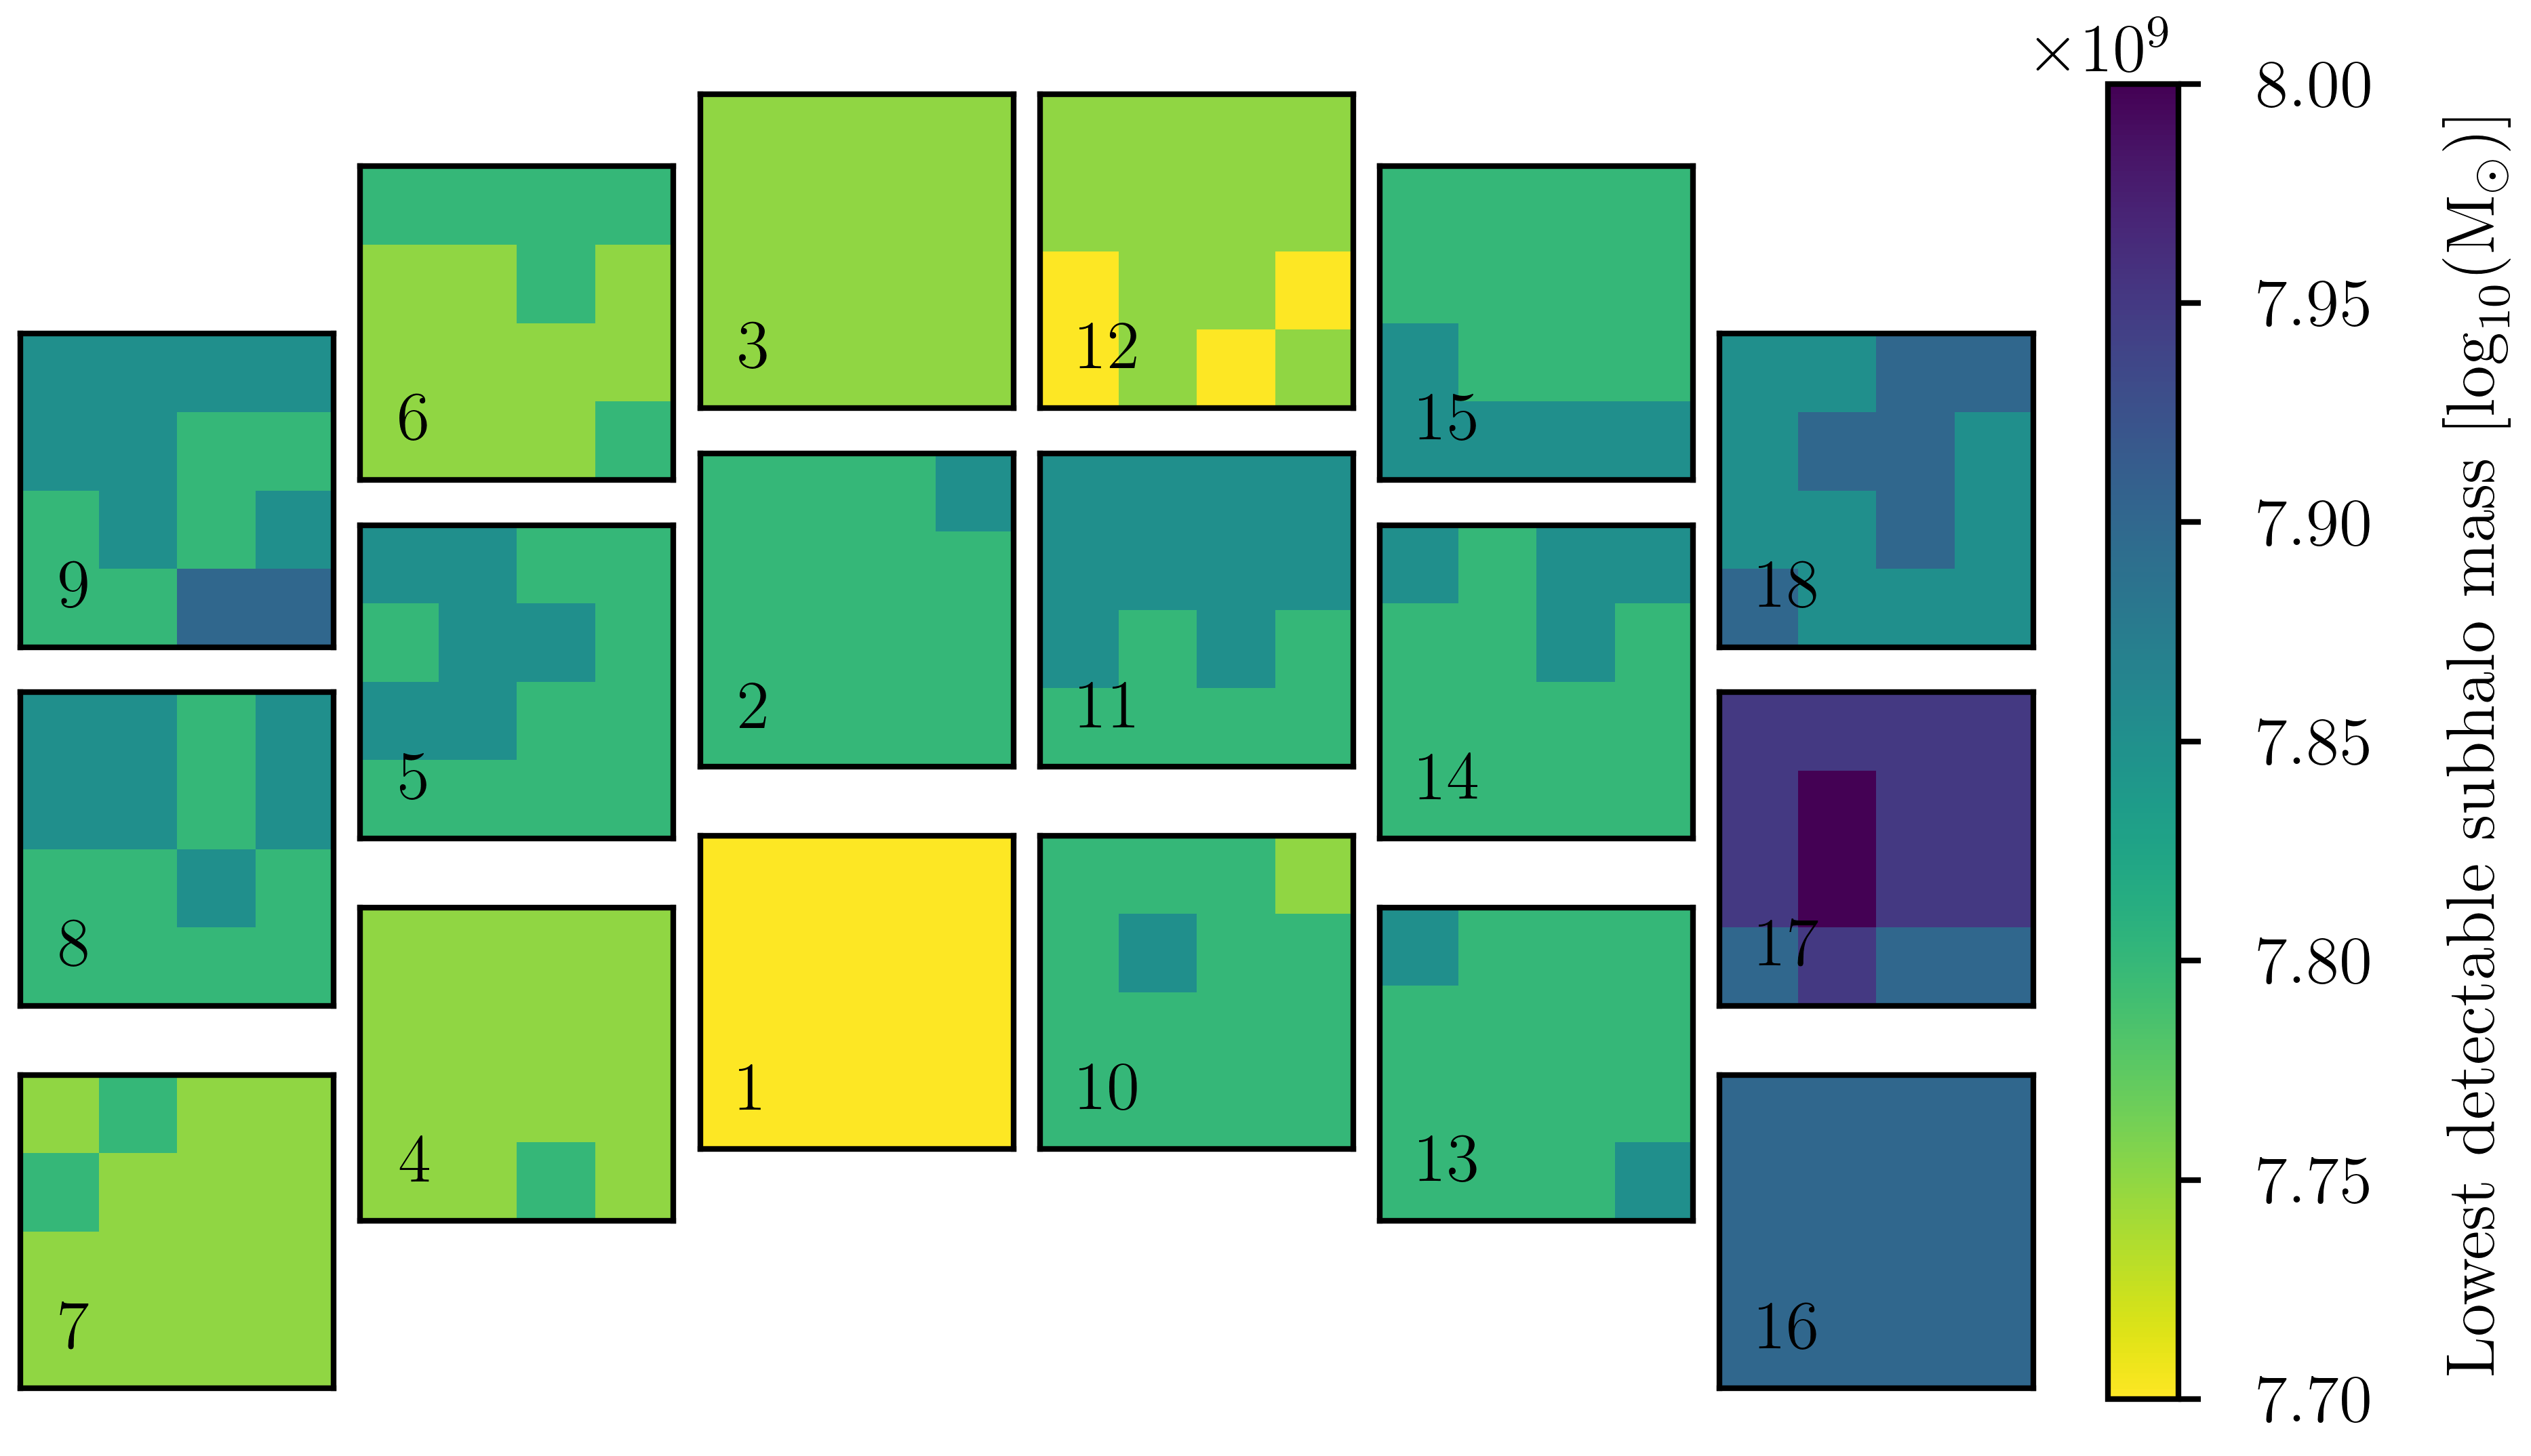

100%|██████████| 288/288 [00:00<00:00, 9738.62it/s]


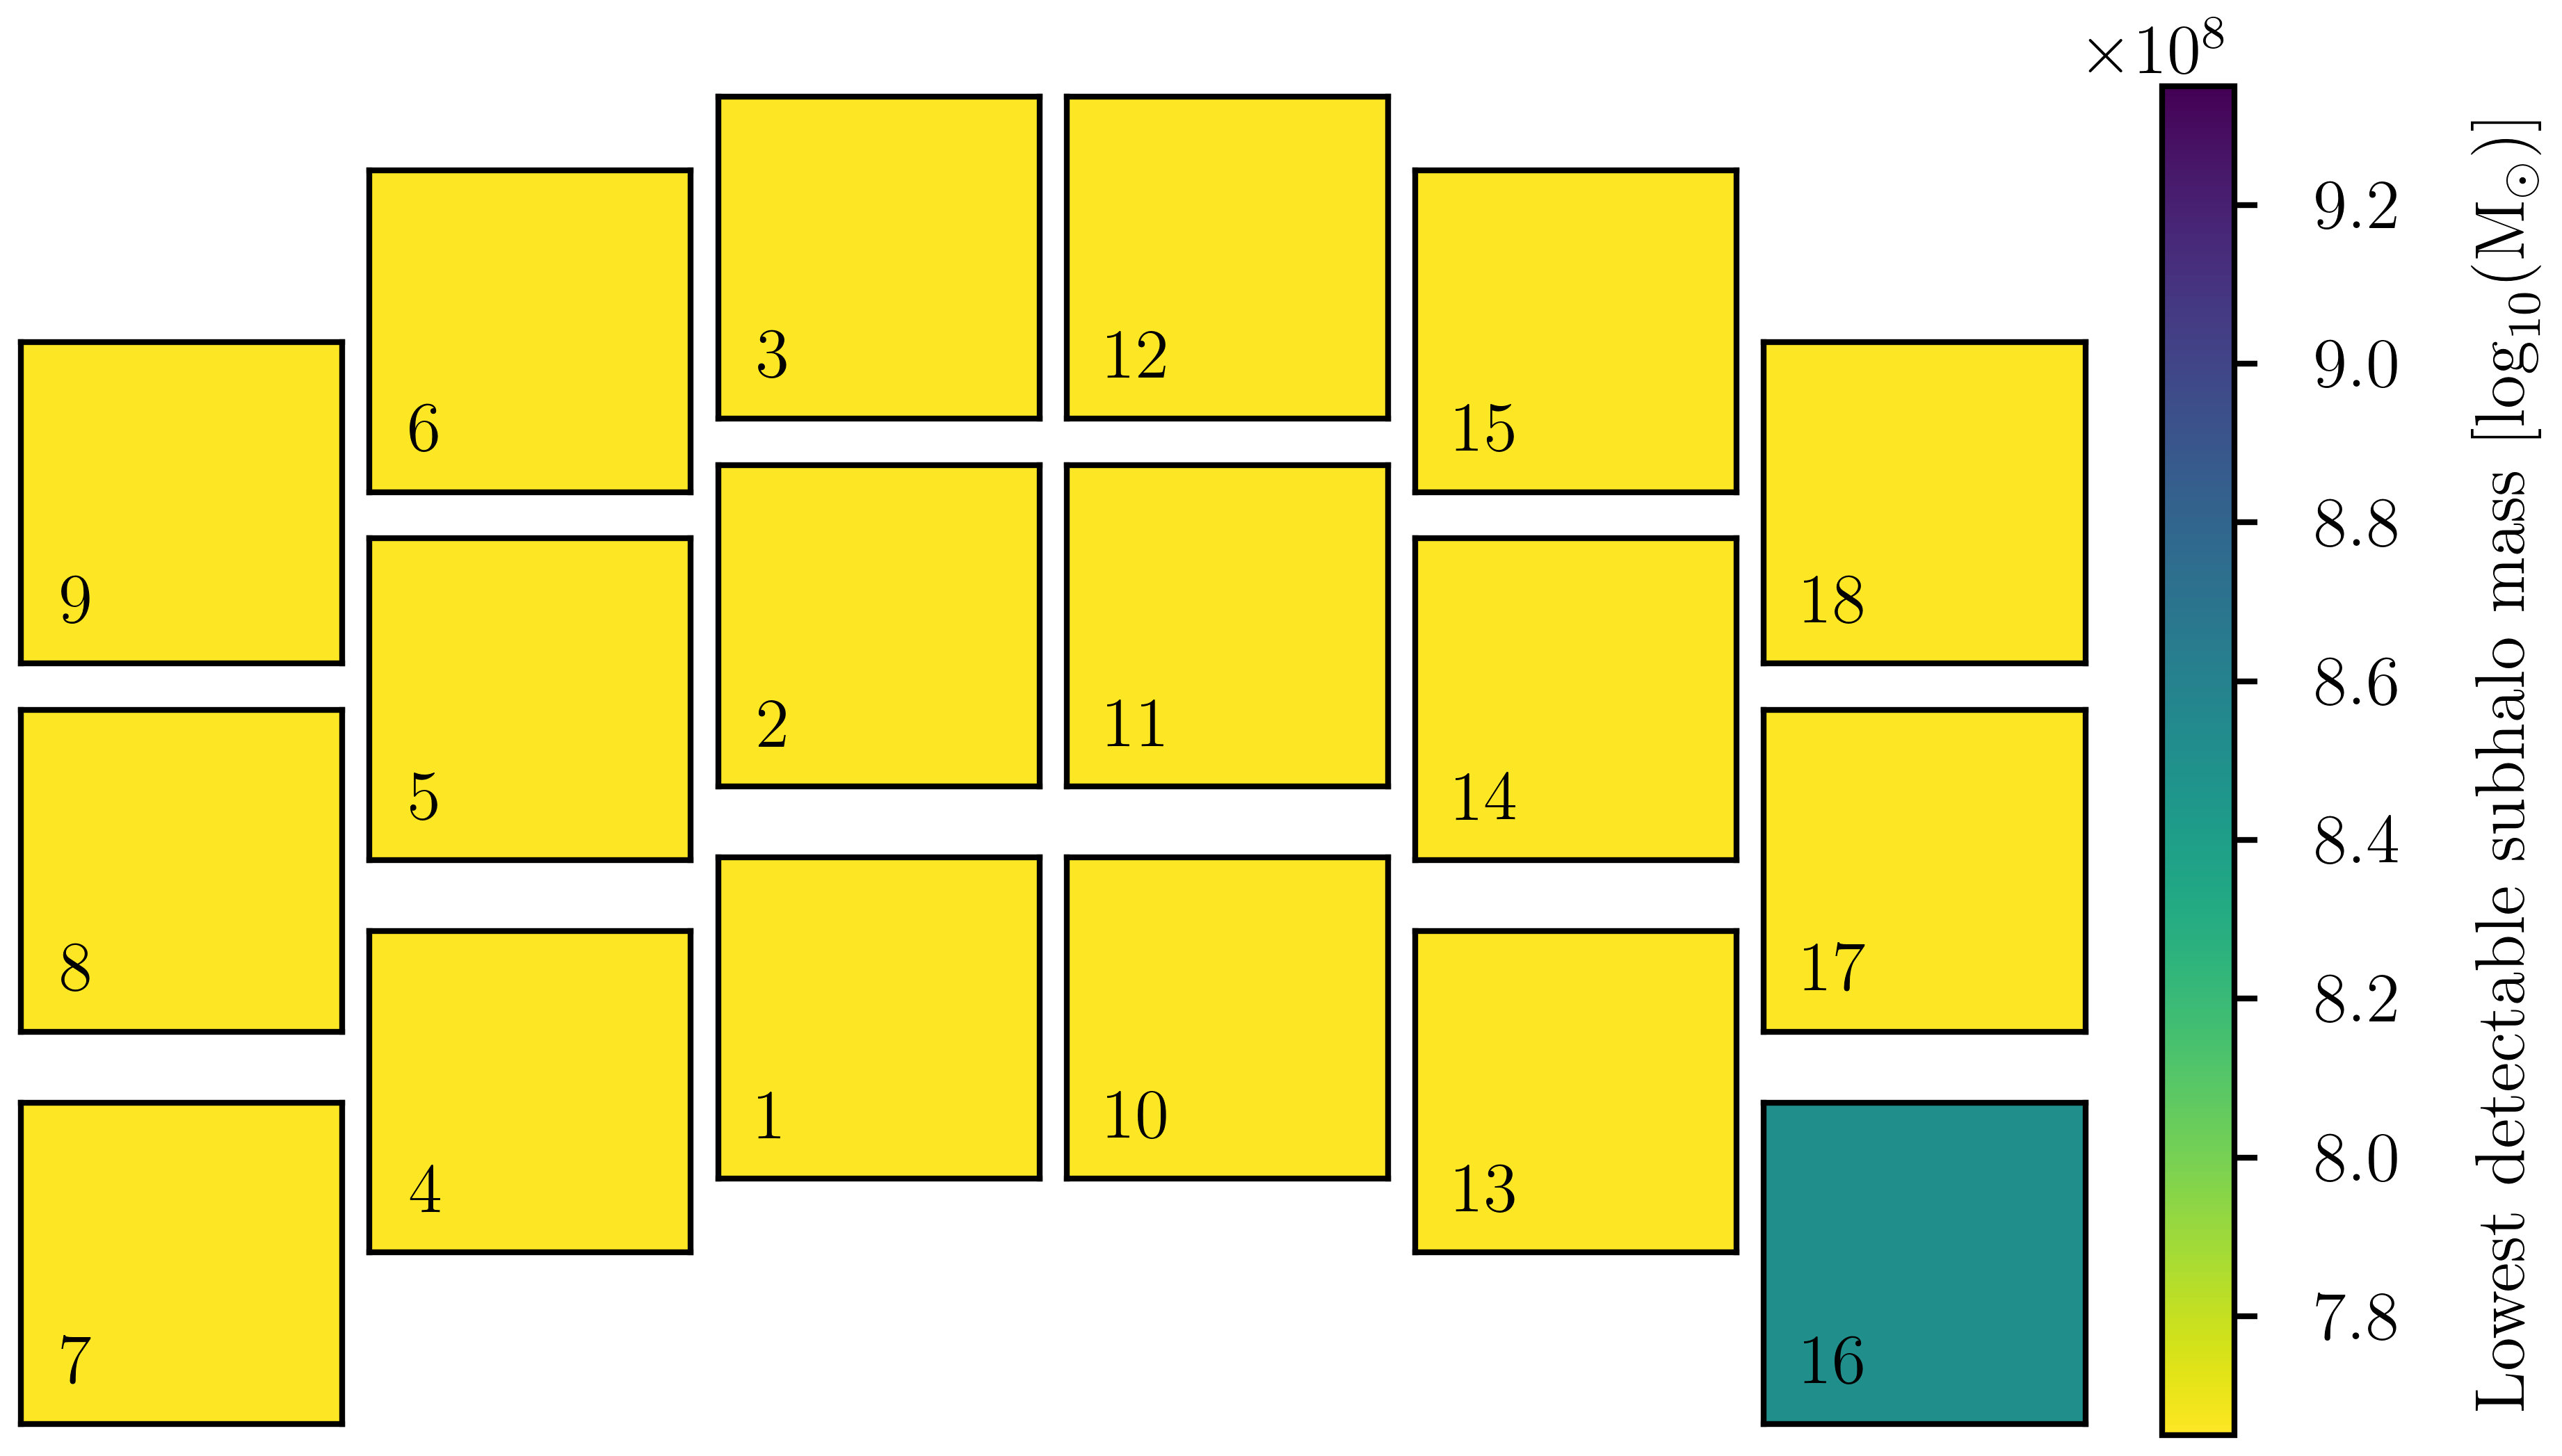

100%|██████████| 288/288 [00:00<00:00, 10590.01it/s]


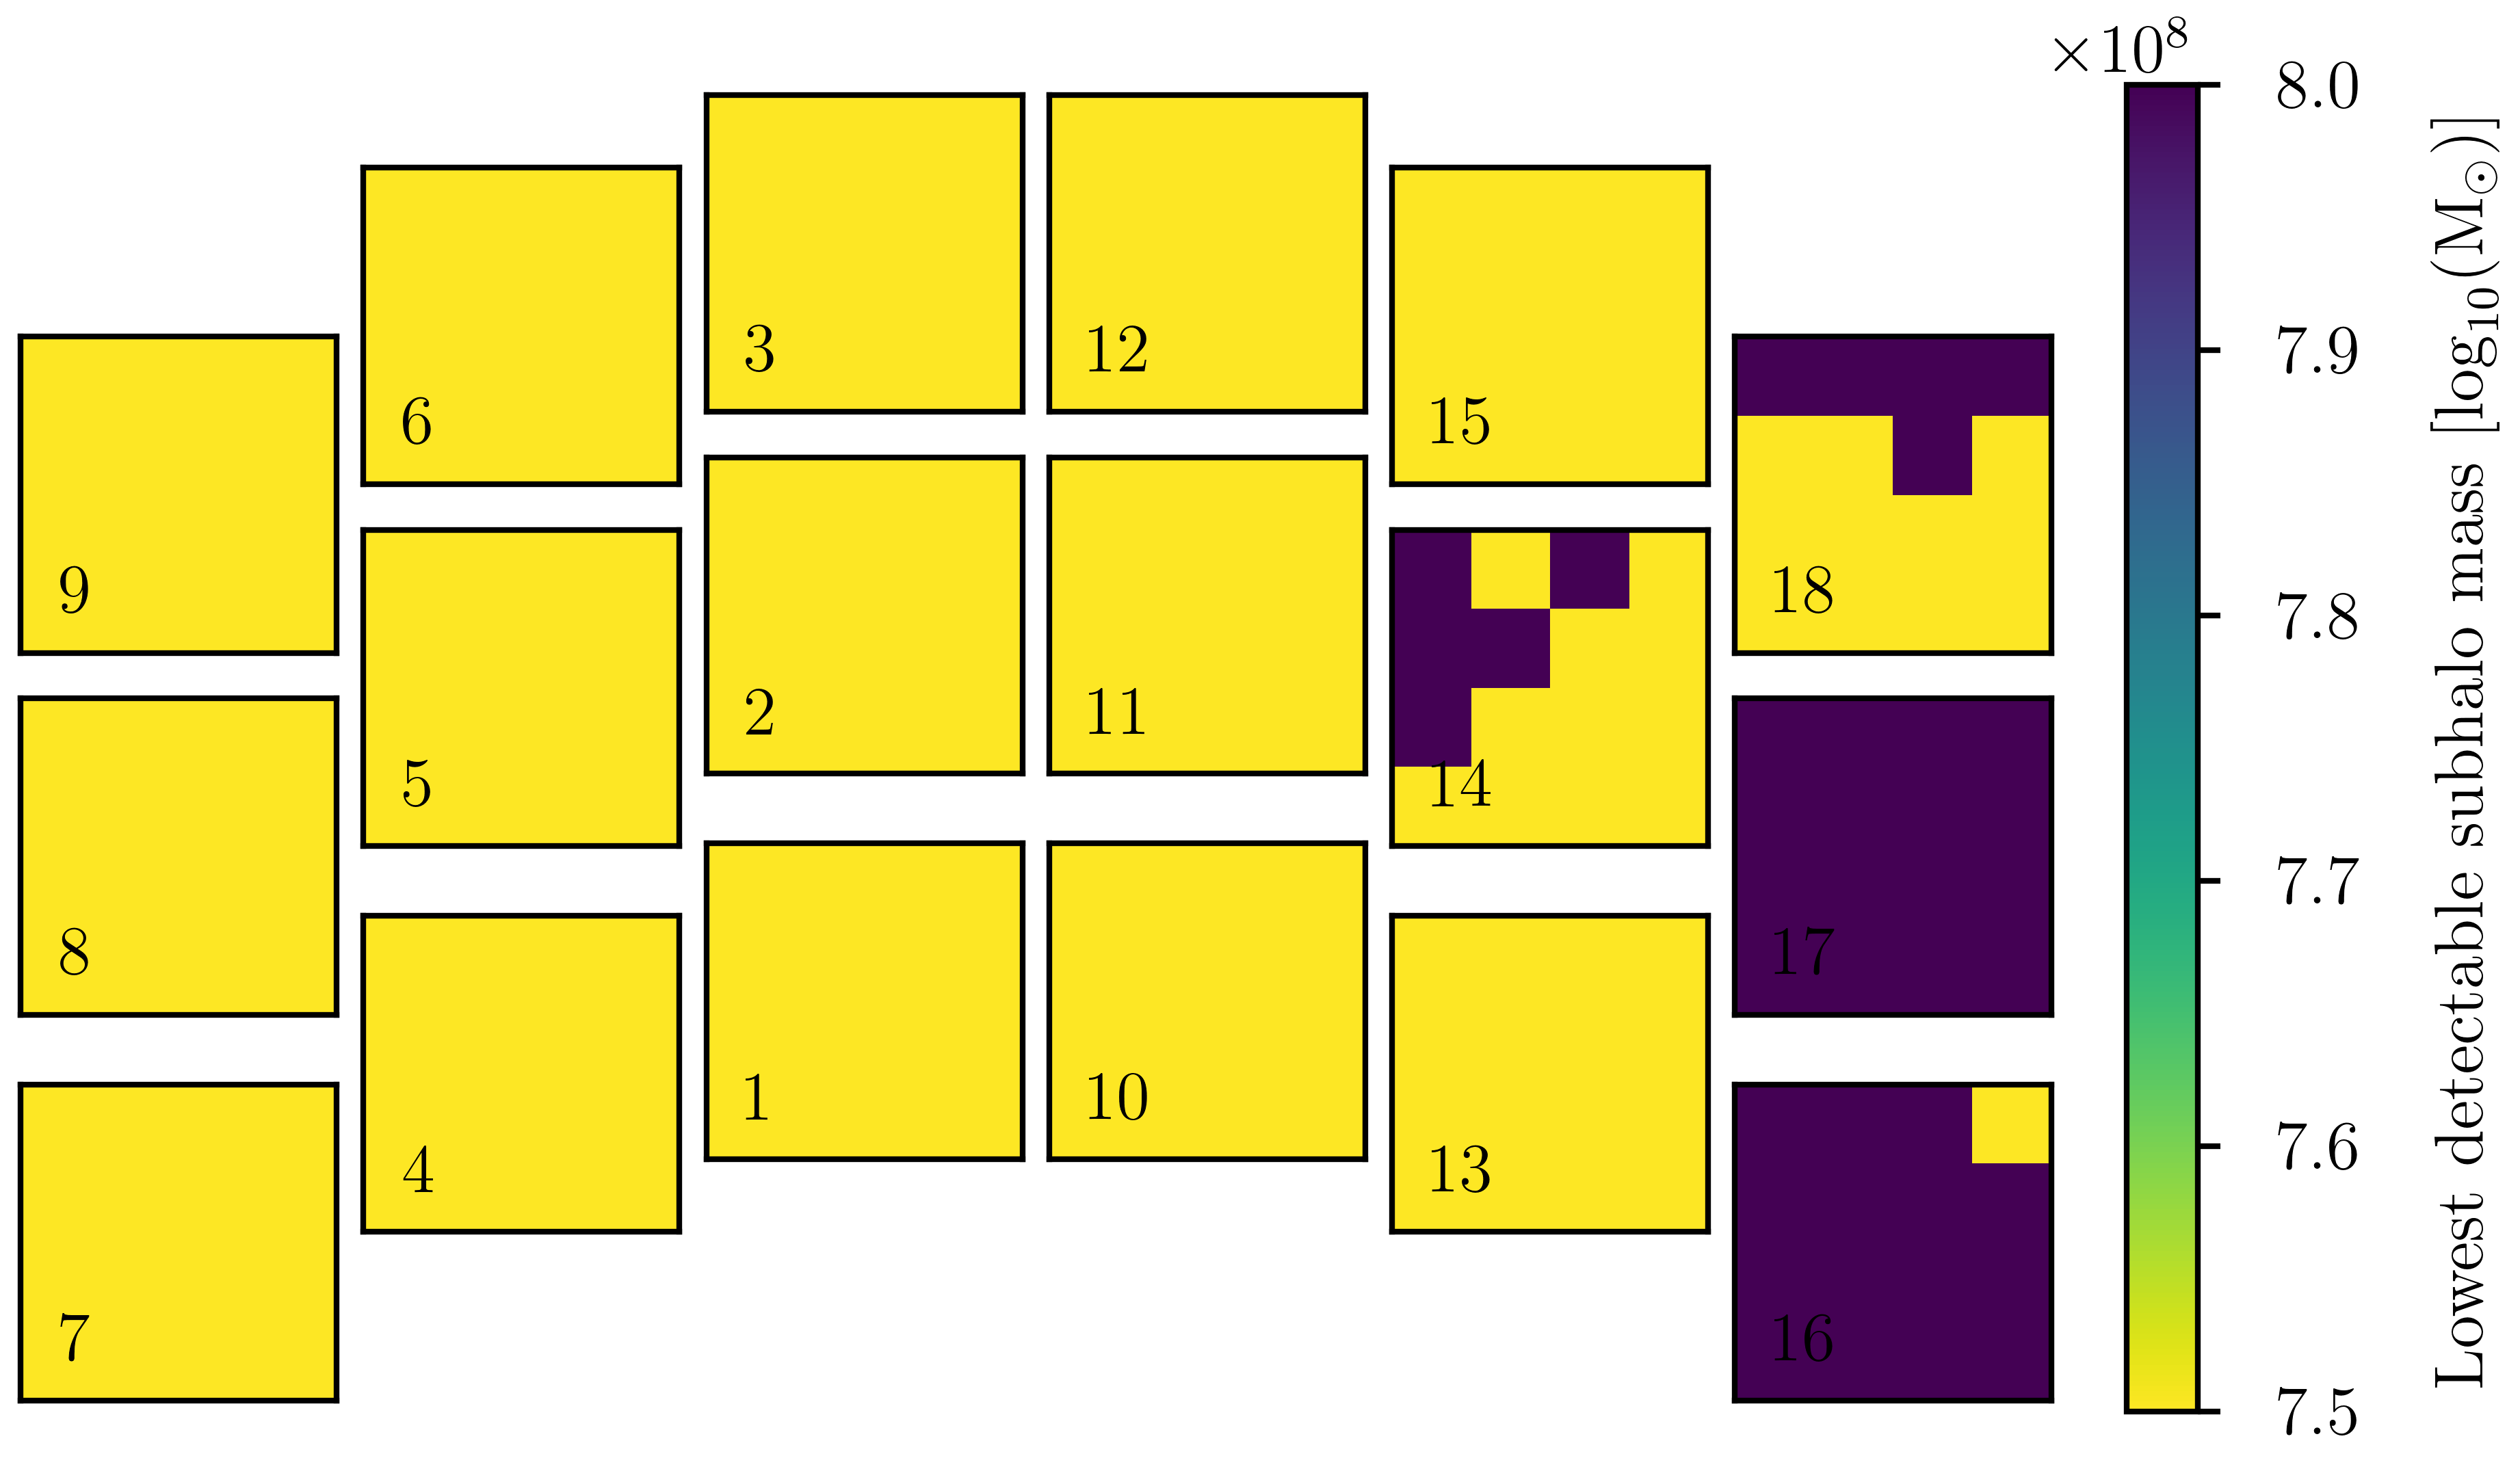

100%|██████████| 288/288 [00:00<00:00, 2564.96it/s]


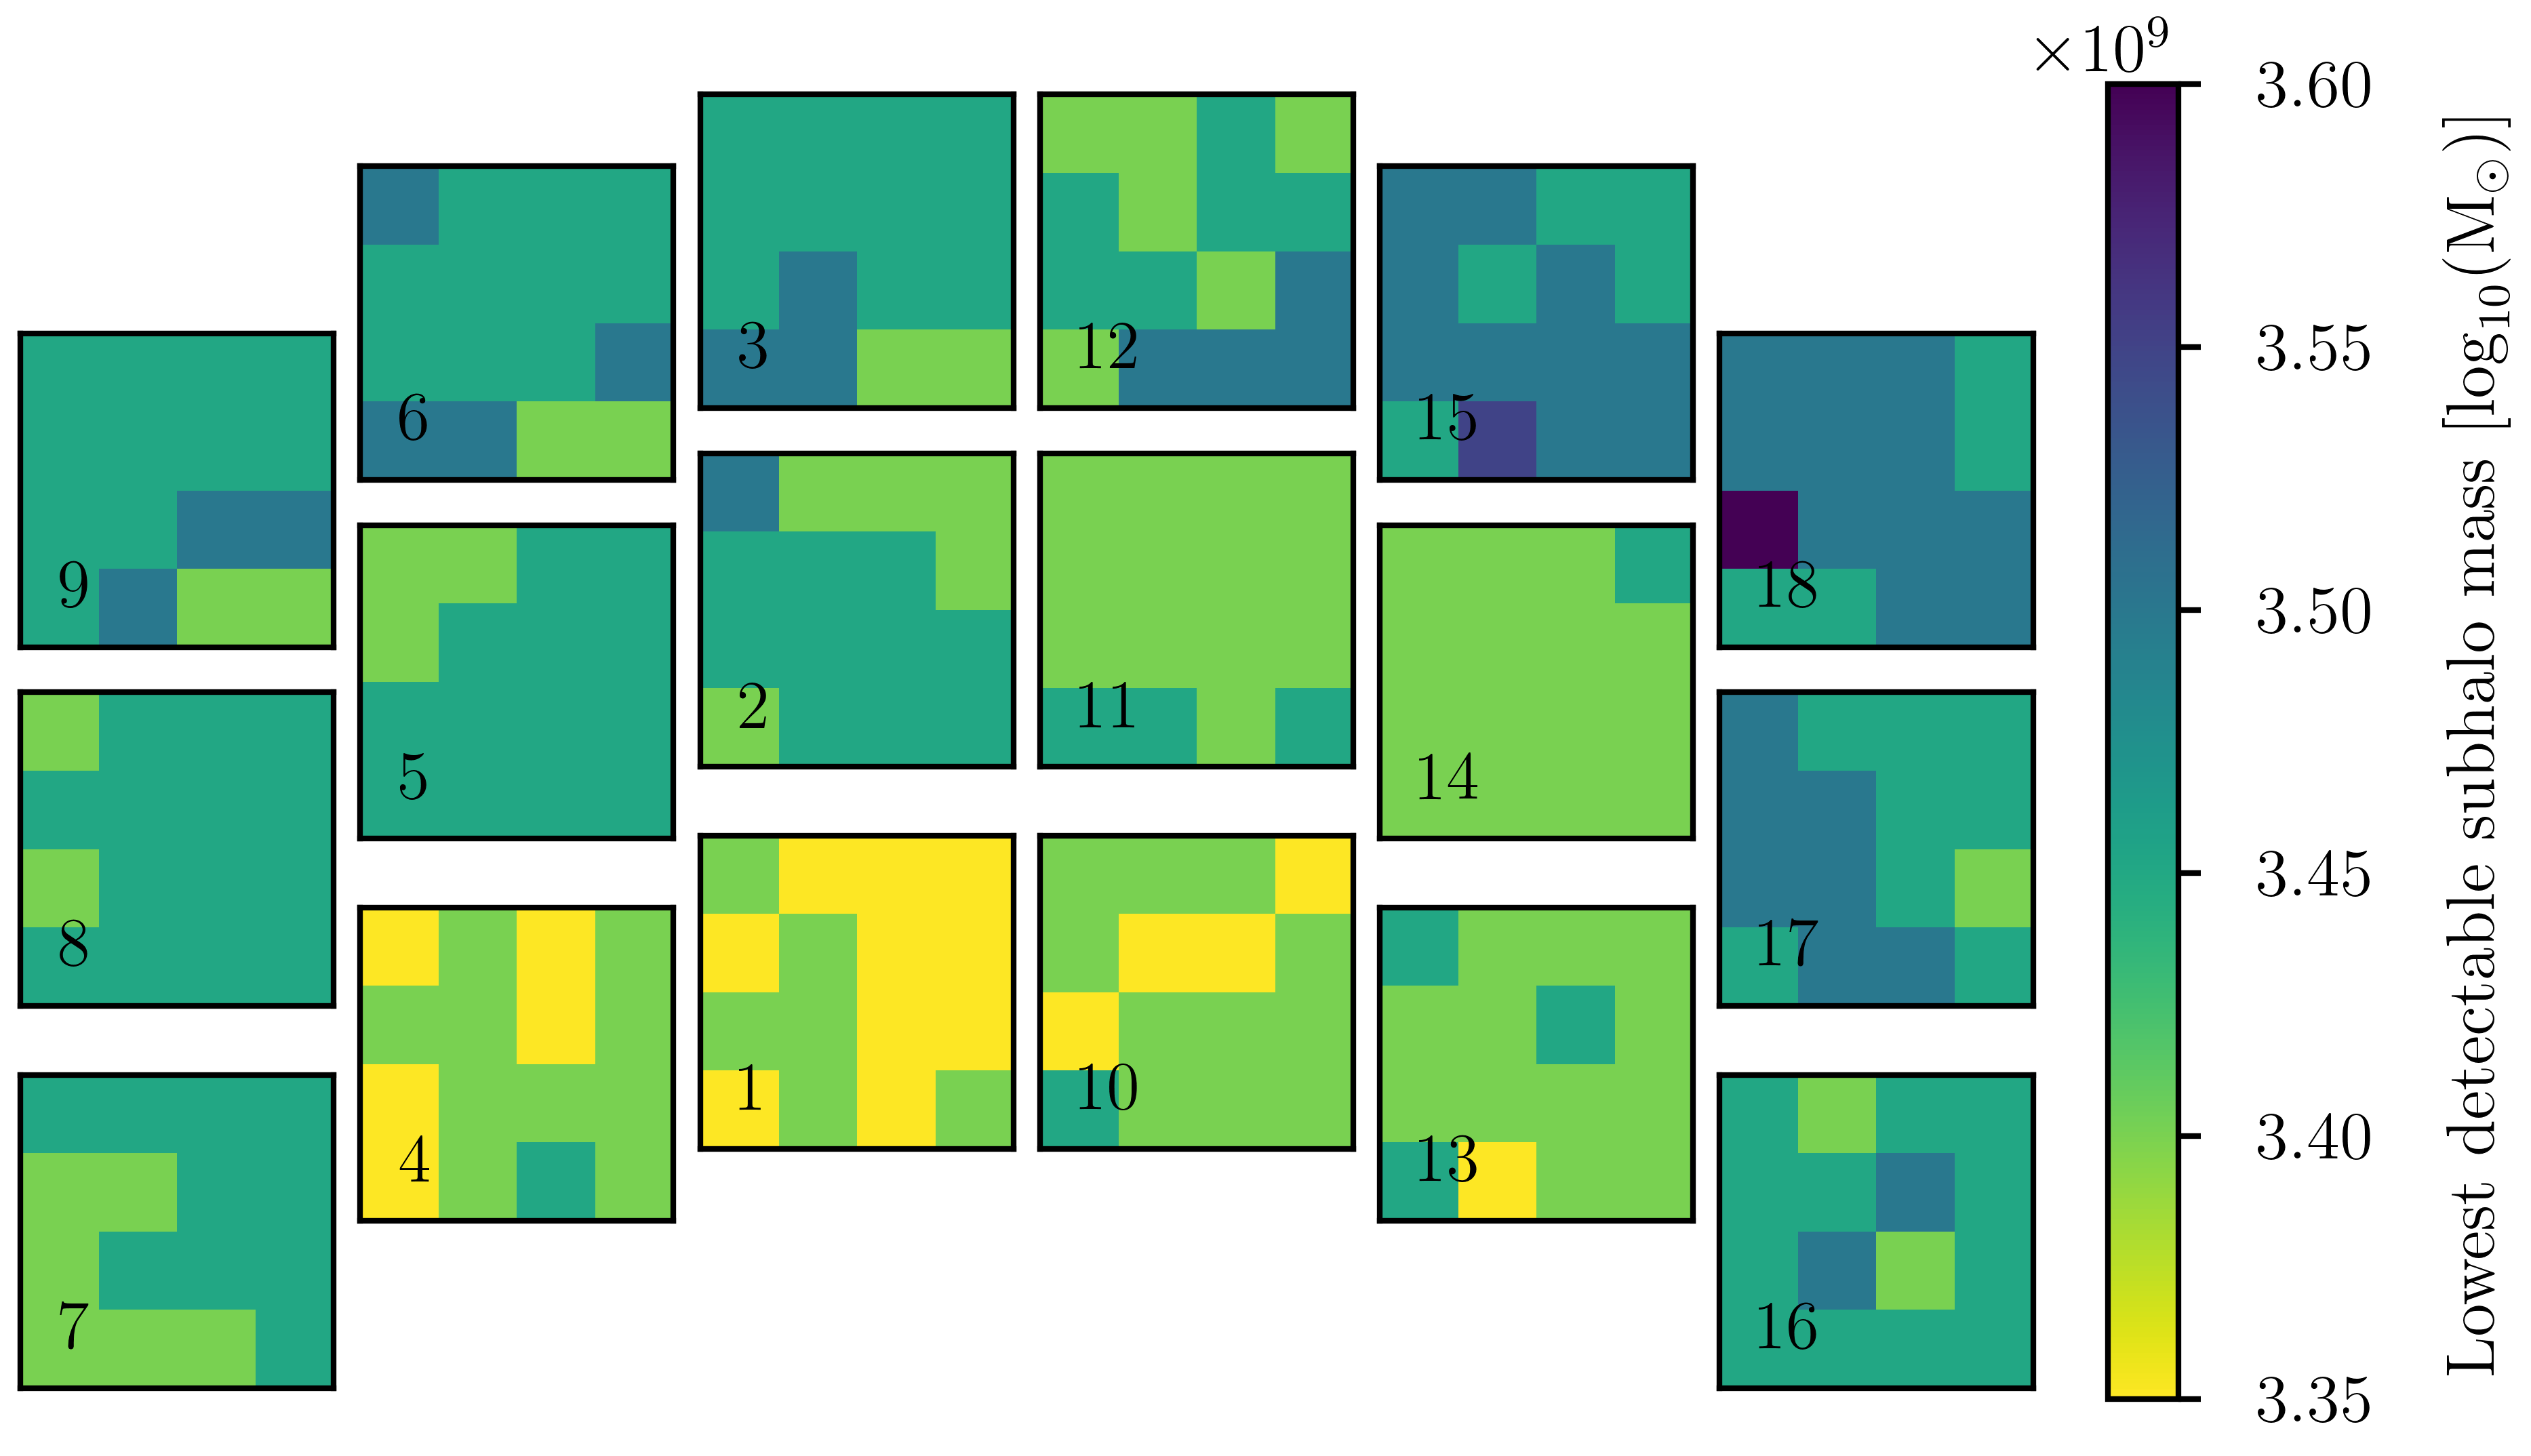

100%|██████████| 288/288 [00:00<00:00, 4453.96it/s]


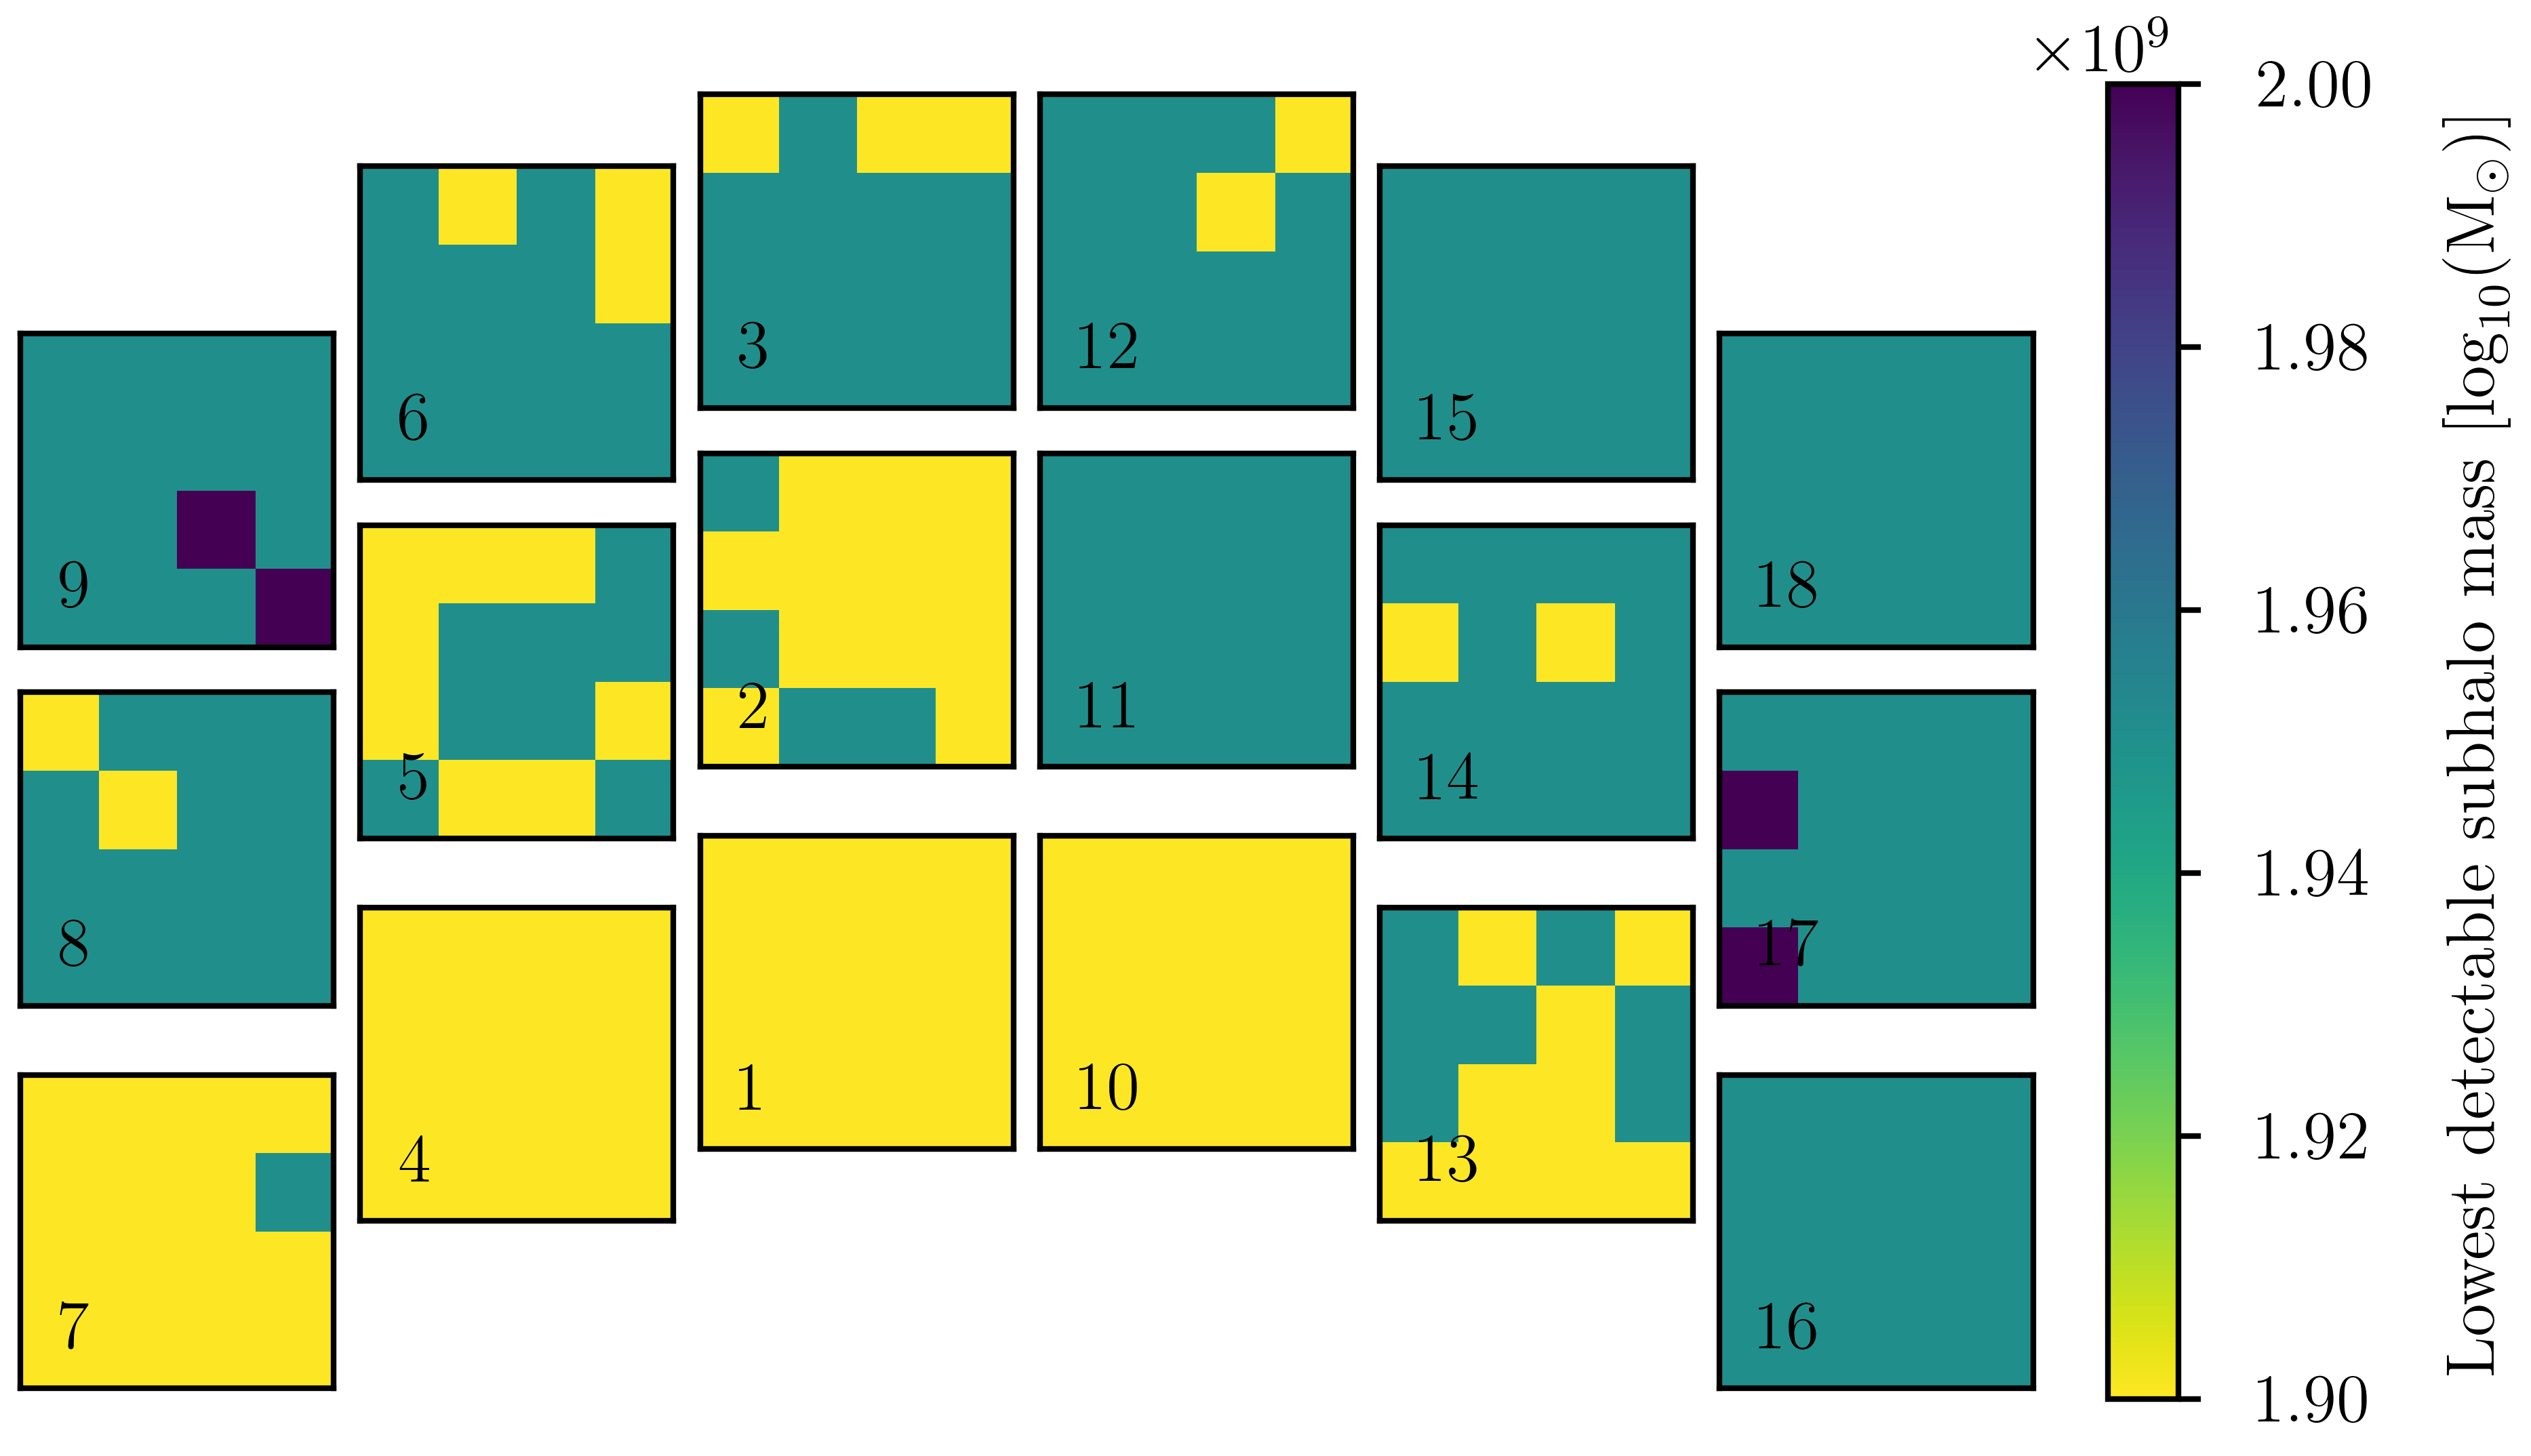

In [29]:
for sample_result in results[:10]:
    array_list = []
    array = np.empty((sides, sides))
    lowest_det_mass_at_position = []

    for sca, sca_position in tqdm(positions):
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = sample_result[position_key]

        for mass in masses:
            pvals = position_results[str(int(mass))]
            mass = float(mass)
            if np.min(pvals) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                lowest_det_mass_at_position.append(mass)
                break

        # if the last position on the SCA has been reached (top-right corner), populate the array with the masses
        if sca_position == roman_util.divide_up_sca(sides)[-1]:  
            for i in range(sides):
                for j in range(sides):
                    array[i, j] = lowest_det_mass_at_position[j * sides + i]

            array_list.append(array)

            # reset the array and median list for the next SCA
            array = np.empty((sides, sides))
            lowest_det_mass_at_position = []

    plotting.roman_sca_plot(np.asarray(array_list), 
                            np.arange(1, 19), 
                            residual_plot=False, 
                            show_sca_id=True, 
                            cmap='viridis_r', 
                            savefig=False, 
                            clabel=r'Lowest detectable subhalo mass [$\log_{10}$(M$_\odot$)]',
                            sca_id_pos=(0,0))

    # vmin, vmax = plot_util.get_min_max(array_list)
    # f, ax = plt.subplots(3, 6, figsize=(12, 6), constrained_layout=True)
    # for i, array in enumerate(array_list):
    #     im = ax[i // 6, i % 6].imshow(array, cmap='viridis', vmin=vmin, vmax=vmax)  # , vmin=np.log10(masses[0]), vmax=np.log10(masses[-1])
    #     ax[i // 6, i % 6].set_title(f'SCA {i + 1}')
    #     ax[i // 6, i % 6].axis('off')
    # cbar = f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    # cbar.set_label(r'Mean Lowest Detectable Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
    # plt.show()